# Detecció de la temàtica principal

Carreguem les llibreries necessàries.

In [7]:
import networkx as nx
import time
from pymongo import MongoClient
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pprint import pprint

import nltk
from nltk import word_tokenize,pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet as wn

import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.phrases import Phrases, Phraser

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

C:\Users\Casa\anaconda3\envs\TFM_8M\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [8]:
import warnings
warnings.filterwarnings('ignore')

En primer lloc, carreguem l'arxiu graphml on tenim els nodes i arestes representants d'Espanya i la comunitat que se li ha sigut assignada.

In [22]:
start = time.time()

G = nx.read_graphml("graphml/8m_k1_spain_coms.graphml")

end = time.time()
print(end - start)

14.56707215309143


Comprovem.

In [4]:
print(nx.number_of_nodes(G))
print(nx.number_of_edges(G))

124434
232118


Una vegada tenim el graf realitzarem els següents passos per a cadascuna de les comunitats elegides:
1. Obtenim els noms dels nodes
2. Guardem el text dels tweets de tots aquests nodes
3. Tractem el text: eliminar caràcters especials, tractar emojis, normalitzar, tokenitzar, lematitzar, etc.
4. Creem un núvol d'etiquetes amb el text tractat
5. Detectem els termes principals de cada temàtica de la comunitat mitjançant LDA

Recordem que les comunitats que hem elegit per analitzar més a fons són les comunitats: 0, 1, 2, 3, 4, 9, 10, 11, 16, 18 i 24.

Com realitzarem els mateixos càlculs per a cada comunitat crearem algunes funcions que ens ajudaran.

In [9]:
def get_nicknames(G, communityId):
    nodes_comunitat = [x for x,y in G.nodes(data=True) if y['comunidad'] == communityId]
    return nodes_comunitat

In [10]:
def get_tweets(usernames, db):
    list_tweets = []    
    
    # Recorrem tots els usuaris i obtenim els missatges que ha publicat
    for user in usernames:
        for tweet in db.tweets.find({"includes.users.0.username":user}): 
            typeTweet = tweet['data']['referenced_tweets'][0]['type'] if 'referenced_tweets' in tweet['data'] else 'original'
            # Depenent si es un retweet o no, accedirem al text d'una forma o altra
            # Si es RT agafarem directament el text original
            if(typeTweet == 'retweeted'):
                list_tweets.append(tweet['includes']['tweets'][0]['text'])
            else:
                list_tweets.append(tweet['data']['text'])

    return list_tweets

In [11]:
def clean_tweets(listTweets):
    # Definim els patrons per detectar contingut
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

    url_pattern = re.compile("http\S+")
    user_pattern = re.compile("@[A-Za-z0-9_]+")
    signs_pattern = re.compile("[^\w.]")
        
    # Eliminem els patrons, els hashtags utilitzats per a la captura i els usuaris
    # Substituïm els patrons per itemDeleted perquè quan utilitzem aquestes dades per crear el model de phrases es mantinga
    # la posició dels elements i no s'ajunten tokens que estan junts per l'eliminació dels patrons i no ho estaven
    # en les dades originals
    clean_tweets = []
    count = 0
    aux = ""
    for count in range(len(listTweets)):
        aux = re.sub(emoji_pattern, 'itemDeleted ', listTweets[count])
        aux = re.sub(url_pattern, 'itemDeleted ', aux)
        aux = re.sub(user_pattern, 'itemDeleted ', aux)
        aux = aux.replace('#8Marzo2022', 'itemdeleted ')
        aux = aux.replace('#8M2022', 'itemDeleted ')
        aux = aux.replace('#8M ', 'itemDeleted ')
        aux = re.sub(signs_pattern, ' ', aux)        
        clean_tweets.append(aux)
        count += 1

    return clean_tweets    

In [12]:
def create_phrases_model(listTweets):
    # Tokenitzem cada tweet
    tokens = [word_tokenize(d.lower()) for d in listTweets]
    
    # Creem el model de Phrases
    phrases_model = Phrases(tokens,delimiter='_')

    # Per ultim, utilitzarem la classe Phraser sobre ell. 
    # Aquest pas serveix per a reduir l'ús de memòria del model, però cal tenir en compte que ja no podrem actualitzar-lo.
    return Phraser(phrases_model)

In [13]:
def get_phrases_filtered_lemmatized(tweet, model, stopwords):
    # Obtenim els tokens
    tokens = word_tokenize(tweet.lower())
    
    # Obtenim les phrases
    phrases = model[tokens]
    
    # Filtrem les phrases
    phrases = filter_phrases(phrases, stopwords)
    
    # Lematitzem les phrases
    lem = WordNetLemmatizer()
    phrases = [lem.lemmatize(s) for s in phrases]
    
    return phrases

In [14]:
def filter_phrases(phrases, stopwords):
    # Filtrem les phrases
    phrases = [p for p in phrases if bool(re.search("[a-z0-9#]", p))]
    phrases = [p.replace('_itemdeleted', '') for p in phrases]
    phrases = [p.replace('itemdeleted_', '') for p in phrases]
    phrases = [p for p in phrases if p != 'itemdeleted']      
    phrases = [delete_stopwords_in_phrase(p, stopwords) for p in phrases if len(delete_stopwords_in_phrase(p, stopwords)) > 0]
    return phrases

In [15]:
def delete_stopwords_in_phrase(phrase, stopwords):
    # Dividim per _
    phrase_split = phrase.split('_')
    phrase_checked = ''
    
    # Comprovem si algun dels token son stopword
    # Sols retornarem els tokens que no siguen stopwords 
    # Si ho son els dos retornarem una cadena buida
    # No ens preocupen per si  la paraula no es multiparaula, les posicions 0 i -1 faram referencia al mateix token
    if(phrase_split[0]) not in stopwords:
        if(phrase_split[-1] not in stopwords):
            phrase_checked = phrase
        else:
            phrase_checked = phrase_split[0]
    elif(phrase_split[-1] not in stopwords):
        phrase_checked = phrase_split[-1]
    
    return phrase_checked

In [16]:
def plot_world_cloud(tokensTweets, exceptionWords=[]):
    # Fiquem els tokens de tots els tweets en un sol string, 
    # La funció WordCloud() treballa sobre un string i no una llista
    # Juntem tots els tokens de cada tweet
    tokens_string = [' '.join([item for item in tokens]) for tokens in tokensTweets]
    
    # Juntem ara tots els tweets 
    tokens_string = ' '.join([item for item in tokens_string])
    
    # Creem el gràfic
    wordcloud = WordCloud(
        collocations=False, 
        background_color='white',
        max_font_size=100, 
        stopwords=exceptionWords, 
        regexp='[\w.]+').generate(tokens_string)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [17]:
def get_modelsLDA_and_coherences(phrases, maxK, passes = 1):
    models_list = []
    coherence_values = []
    dictionary = corpora.Dictionary(phrases)

    for num_topics in range(2, maxK, 1):
        model = lda(phrases, num_topics, passes)
        models_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=phrases, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    
    return models_list, coherence_values

In [18]:
def lda(terms, num_topics, passes):
    
    # Creació del diccionari i del corpus de text amb les frequencies d'aparició de cada terme
    dictionary = corpora.Dictionary(terms)
    corpus = [dictionary.doc2bow(t) for t in terms]
    
    #Creació del model
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_topics, random_state=1, id2word = dictionary, passes=passes) 
    
    return ldamodel

In [19]:
def plot_coherences(coherences, maxK):
    x = range(2, maxK, 1)
    plt.plot(x, coherences)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

In [20]:
def plot_pyLDAvis(phrases, modelLDA):
    dictionary = corpora.Dictionary(phrases)
    corpus = [dictionary.doc2bow(text) for text in phrases]
    return gensimvis.prepare(modelLDA, corpus, dictionary)

Obrim la connexió a la base de dades.

In [16]:
client = MongoClient()
db = client.dades_8m

Abans de passar a analitzar cada comunitat carreguem les stopwords en l'idioma castellà i afegim algunes paraules que hem vist que no estan incloses.

In [325]:
stopwords = nltk.corpus.stopwords.words('spanish')
stopwords += ['si', 'día', 'hoy', 'mujer', 'mujeres', 'mujere', 'feminismo', 'toda', 'todas', '8m', 'igualdad']

### Comunitat 0

**Obtenció dels missatges**

Obtenim els nodes de la comunitat.

In [63]:
nodes_com_0 = get_nicknames(G, 0)
len(nodes_com_0)

16813

Ara extraiem el text dels missatges publicats per aquests nodes i els guardem en una llista.

In [20]:
start = time.time()
tweets_com_0 = get_tweets(nodes_com_0, db)

end = time.time()
print(end - start)

29278.84903216362


Comprovem.

In [21]:
len(tweets_com_0)

42696

Guardem els tweets en un fitxer de text per poder accedir a ells fàcilment en un futur.

Per guardar-los eliminarem els salts de línia dels tweets. Ho fem així per tenir en el fitxer cada tweet en una línia.

In [22]:
f = open('tweets/tweets_comunitats/com_0_tweets.txt', 'w', encoding='utf-8')

for tweet in tweets_com_0:
    f.write(tweet.replace('\n', ' ')+'\n')
        
f.close()

Obrim el fitxer i treballem sobre les dades.

In [18]:
with open('tweets/tweets_comunitats/com_0_tweets.txt', 'r', encoding='utf-8') as f:
    com_0_tweets = f.readlines()
    print(com_0_tweets[0:5])

['Hoy las feministas no la recordarán pese a que gracias a mujeres como ella, su vida vale más que un camello.  Isabel I de Castilla, la Católica, su determinación nos libró del yugo musulmán.  #Reconqvista. ¡GLORIA Y HONOR! #8M2022 #8Marzo2022 #8M https://t.co/EqThH0Yezs\n', '#8M 𝗥𝗘́𝗖𝗢𝗥𝗗 𝗛𝗜𝗦𝗧𝗢́𝗥𝗜𝗖𝗢     𝗣𝗥𝗘𝗖𝗜𝗢 𝗗𝗘 𝗟𝗔 𝗟𝗨𝗭 #8MRecordPrecioLuz https://t.co/T5HOFkYUhs\n', 'El #8M2022 que nos vende Irene Montero, no se lo creen ni ellos.   👇En Podemos creen en la igualdad, pero no tanto. https://t.co/JyyOsAspJU\n', '🔴 Última hora sobre lo que hoy, #8Marzo2022, ha sucedido en #Melilla. Donde 400 inmigrantes ilegales han protagonizado un nuevo asalto fronterizo.  🗣 Hay miles de subsaharianos que están esperando para entrar en territorio español.  📺 VIDEO COMPLETO: https://t.co/ljyZ7EUAYu https://t.co/9z4vDBiIbc\n', '#8M 𝗥𝗘́𝗖𝗢𝗥𝗗 𝗛𝗜𝗦𝗧𝗢́𝗥𝗜𝗖𝗢     𝗣𝗥𝗘𝗖𝗜𝗢 𝗗𝗘 𝗟𝗔 𝗟𝗨𝗭 #8MRecordPrecioLuz https://t.co/T5HOFkYUhs\n']


Comprovem.

In [19]:
len(com_0_tweets)

42696

**Preparació del text**

Una vegada ja tenim els missatges dels usuaris de les comunitats, passa'm a netejar-los. L'objectiu és eliminar tot el soroll possible i preparar el text per a obtenir el núvol de paraules i aplicar l'algoritme LDA de detecció de temes. Farem servir la funció *clean_tweets()* que hem creat.

In [20]:
start = time.time()

com_0_clean_tweets = clean_tweets(com_0_tweets)

end = time.time()
print(end - start)

0.7350337505340576


In [21]:
com_0_clean_tweets[0:3]

['Hoy las feministas no la recordarán pese a que gracias a mujeres como ella  su vida vale más que un camello.  Isabel I de Castilla  la Católica  su determinación nos libró del yugo musulmán.   Reconqvista.  GLORIA Y HONOR  itemDeleted  itemdeleted  itemDeleted itemDeleted  ',
 'itemDeleted 𝗥𝗘 𝗖𝗢𝗥𝗗 𝗛𝗜𝗦𝗧𝗢 𝗥𝗜𝗖𝗢     𝗣𝗥𝗘𝗖𝗜𝗢 𝗗𝗘 𝗟𝗔 𝗟𝗨𝗭  8MRecordPrecioLuz itemDeleted  ',
 'El itemDeleted  que nos vende Irene Montero  no se lo creen ni ellos.   itemDeleted En Podemos creen en la igualdad  pero no tanto. itemDeleted  ']

Ja tenim el corpus de tweets amb una primera neteja. Ara creem el model de phraes per a aquest corpus de text.

In [22]:
start = time.time()

com_0_model_phrases = create_phrases_model(com_0_clean_tweets)

end = time.time()
print(end - start)

9.616389989852905


In [23]:
com_0_model_phrases

Ara utilitzarem aquest model de phrases per filtrar i lematitzar els tokens de cada tweet. L'objectiu d'aquest procés és eliminar el màxim soroll possible i normalitzar mitjançant la lematització.

In [24]:
start = time.time()

com_0_phrases = [get_phrases_filtered_lemmatized(s, com_0_model_phrases, stopwords) for s in com_0_clean_tweets]

end = time.time()
print(end - start)

20.038650035858154


Comprovem.

In [25]:
com_0_phrases[0:3]

[['feministas',
  'recordarán_pese',
  'gracias',
  'vida_vale',
  'camello',
  'isabel_i',
  'castilla',
  'católica',
  'determinación',
  'libró',
  'yugo_musulmán',
  'reconqvista',
  'gloria',
  'honor'],
 ['8mrecordprecioluz'],
 ['vende', 'irene_montero', 'creen', 'podemos_creen']]

**Creació del núvol de paraules**

A partir d'aquestes phrases lematitzades i filtrades per eliminar gran part del soroll, creem un núvol de paraules on veure quines han sigut les més repetides en els missatges de la comunitat.

Açò ens donarà una idea general de com ha sigut la conversació.

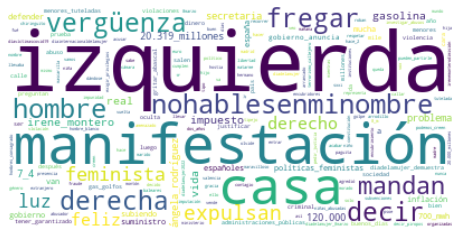

1.2774848937988281


In [38]:
start = time.time()

plot_world_cloud(com_0_phrases)    
    
end = time.time()
print(end - start)

Busquem la paraula fregar per veure en quins tweets apareix. Mirem els 10 primers.

In [158]:
count = 0
for tweet in com_0_tweets:
    if 'fregar' in tweet:
        print(tweet)
        count +=1
    if count >= 10:
        break

Expulsan a una mujer del #8M por decir que es de derechas y la mandan “a su casa a fregar”  Esto es el feminismo de la izquierda y es una vergüenza. https://t.co/itMDnPOJxe

Expulsan a una mujer del #8M por decir que es de derechas y la mandan “a su casa a fregar”  Esto es el feminismo de la izquierda y es una vergüenza. https://t.co/itMDnPOJxe

Expulsan a una mujer del #8M por decir que es de derechas y la mandan “a su casa a fregar”  Esto es el feminismo de la izquierda y es una vergüenza. https://t.co/itMDnPOJxe

Expulsan a una mujer del #8M por decir que es de derechas y la mandan “a su casa a fregar”  Esto es el feminismo de la izquierda y es una vergüenza. https://t.co/itMDnPOJxe

Expulsan a una mujer del #8M por decir que es de derechas y la mandan “a su casa a fregar”  Esto es el feminismo de la izquierda y es una vergüenza. https://t.co/itMDnPOJxe

Expulsan a una mujer del #8M por decir que es de derechas y la mandan “a su casa a fregar”  Esto es el feminismo de la izquierda y

**Detecció temàtiques amb LDA**

Tenim les phrases ja tractades. Ara passem a detectar els temes de la comunitat.

Ho farem mitjançant LDA.

Farem servir la funció *get_modelsLDA_and_coherences()* per obtenir diversos models amb distint nombre de temes.

In [129]:
start = time.time()

com_0_modelsLDA, com_0_coherences = get_modelsLDA_and_coherences(com_0_phrases, 10, 10)

end = time.time()
print(end - start)

487.88068675994873


Una vegada calculades les coherències de tots els models podem comparar-les en un gràfic:

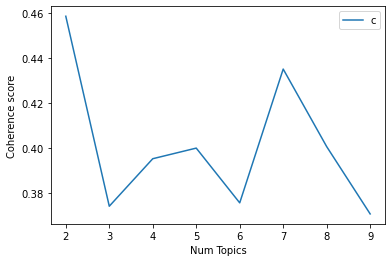

In [130]:
plot_coherences(com_0_coherences, 10)

Una altra ferramenta que ens pot ajudar a elegir la temàtica és la visualització mitjançant pyLDAvis.

A continuació carregarem les llibreries necessàries per a fer aquesta visualització i representarem els models creats amb 2 i 7

In [175]:
plot_pyLDAvis(com_0_phrases, com_0_modelsLDA[0])

PreparedData(topic_coordinates=             x    y  topics  cluster       Freq
topic                                          
1      0.26701  0.0       1        1  55.766615
0     -0.26701  0.0       2        1  44.233385, topic_info=              Term         Freq        Total Category  logprob  loglift
136      izquierda  8274.000000  8274.000000  Default  30.0000  30.0000
135         fregar  7785.000000  7785.000000  Default  29.0000  29.0000
131           casa  7724.000000  7724.000000  Default  28.0000  28.0000
133       derechas  7612.000000  7612.000000  Default  27.0000  27.0000
138      vergüenza  7542.000000  7542.000000  Default  26.0000  26.0000
..             ...          ...          ...      ...      ...      ...
269        después  1311.036231  1416.145360   Topic2  -4.8721   0.7386
363            7_4  1486.103457  1694.134373   Topic2  -4.7468   0.6847
169              2  1574.130675  2045.945124   Topic2  -4.6892   0.5535
85   manifestación  1809.315983  3713.229172   Topic2  -4.5500   0.0967
402          feliz  1481.965020  2678.635378   Topic2  -4.7496   0.2238

[103 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
831       2  0.999722           120.000
169       1  0.230700                 2
169       2  0.769327                 2
139       2  0.999852   20.319_millones
362       2  0.999844           700_mwh
...     ...       ...               ...
590       1  0.998995         violencia
590       2  0.001220         violencia
178       1  0.999240            vuelta
178       2  0.001050            vuelta
833       2  0.999658  ángela_rodríguez

[115 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [176]:
plot_pyLDAvis(com_0_phrases, com_0_modelsLDA[5])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.416874  0.020084       1        1  18.171086
4      0.066908  0.276991       2        1  15.277060
2      0.146767  0.067375       3        1  14.565396
3      0.082356  0.008624       4        1  13.628086
0      0.080775 -0.219385       5        1  13.269400
5      0.019914 -0.246889       6        1  13.159500
6      0.020155  0.093199       7        1  11.929472, topic_info=               Term         Freq        Total Category  logprob  loglift
135          fregar  5462.000000  5462.000000  Default  30.0000  30.0000
133        derechas  5340.000000  5340.000000  Default  29.0000  29.0000
138       vergüenza  5291.000000  5291.000000  Default  28.0000  28.0000
132           decir  5213.000000  5213.000000  Default  27.0000  27.0000
137          mandan  5168.000000  5168.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
1664     castellana   250.846784   317.031431   Topic7  -5.2154   1.8920
700           hacer   316.253373   672.287930   Topic7  -4.9837   1.3720
136       izquierda   598.240980  6147.153326   Topic7  -4.3462  -0.2036
16    irene_montero   321.803072  2167.599527   Topic7  -4.9663   0.2187
93     diadelamujer   243.893184   571.404611   Topic7  -5.2435   1.2748

[317 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
2023      7  0.997550                 0
831       6  0.999528           120.000
169       4  0.741934                 2
169       6  0.257636                 2
769       2  0.102864   20.000_millones
...     ...       ...               ...
438       2  0.741617               vox
438       7  0.256714               vox
178       6  0.999289            vuelta
537       4  0.992581            vuelto
833       6  0.999368  ángela_rodríguez

[389 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 3, 4, 1, 6, 7])

Per a veure amb detall els termes principals d'aquestes temàtiques farem servir la llibreria pprint i la funció print_topics() dels models.

In [177]:
pprint(com_0_modelsLDA[0].print_topics()) 

[(0,
  '0.014*"impuestos" + 0.014*"luz" + 0.013*"secretaria" + 0.013*"120.000" + '
  '0.013*"ángela_rodríguez" + 0.012*"gasolina" + 0.011*"manifestación" + '
  '0.010*"20.319_millones" + 0.010*"políticas_feministas" + 0.009*"700_mwh"'),
 (1,
  '0.038*"izquierda" + 0.036*"fregar" + 0.036*"casa" + 0.035*"derechas" + '
  '0.035*"vergüenza" + 0.034*"decir" + 0.034*"mandan" + 0.034*"expulsan" + '
  '0.012*"nohablesenminombre" + 0.009*"manifestación"')]


In [178]:
pprint(com_0_modelsLDA[5].print_topics()) 

[(0,
  '0.032*"feliz" + 0.019*"días" + 0.017*"año" + 0.017*"8_m" + 0.017*"dinero" + '
  '0.016*"feminista" + 0.016*"puerta" + 0.016*"abran" + 0.016*"llamen" + '
  '0.016*"pasión"'),
 (1,
  '0.078*"izquierda" + 0.078*"fregar" + 0.076*"casa" + 0.076*"derechas" + '
  '0.075*"vergüenza" + 0.074*"decir" + 0.073*"mandan" + 0.073*"expulsan" + '
  '0.019*"manifestación" + 0.010*"defender"'),
 (2,
  '0.030*"feliz" + 0.016*"hombre" + 0.014*"españa" + 0.014*"queda" + '
  '0.013*"llevar" + 0.012*"recorrer" + 0.012*"entonces" + 0.012*"llevaba" + '
  '0.012*"cartera" + 0.012*"solitario"'),
 (3,
  '0.039*"luz" + 0.038*"gasolina" + 0.031*"20.319_millones" + '
  '0.031*"políticas_feministas" + 0.029*"700_mwh" + 0.029*"2" + '
  '0.028*"inflación" + 0.027*"a" + 0.027*"subiendo" + 0.027*"suministro"'),
 (4,
  '0.048*"nohablesenminombre" + 0.034*"real" + 0.031*"problemas" + '
  '0.029*"hombre" + 0.024*"oculta" + 0.010*"irenemonterodimisión" + '
  '0.010*"representa" + 0.010*"arrodillo" + 0.010*"decido" + '

Ens quedem amb k = 2, ja que engloba de millor forma les distintes temàtiques de les quals ha tractat la conversació en aquesta comunitat.

Per a les següents comunitats aplicarem directament les funcions per no repetir-nos amb les explicacions.

### Comunitat 1

**Obtenció dels missatges**

In [25]:
nodes_com_1 = get_nicknames(G, 1)
len(nodes_com_1)

16674

In [26]:
start = time.time()
tweets_com_1 = get_tweets(nodes_com_1, db)

end = time.time()
print(end - start)

28516.83288049698


In [27]:
len(tweets_com_1)

26366

In [28]:
f = open('tweets/tweets_comunitats/com_1_tweets.txt', 'w', encoding='utf-8')

for tweet in tweets_com_1:
    f.write(tweet.replace('\n', ' ')+'\n')
        
f.close()

In [28]:
with open('tweets/tweets_comunitats/com_1_tweets.txt', 'r', encoding='utf-8') as f:
    com_1_tweets = f.readlines()
    print(com_1_tweets[0:5])

['✅ La ministra @IreneMontero comparece hoy tras el #CMin para informar sobre la aprobación del III Plan Estratégico de Igualdad Efectiva entre Mujeres y Hombres 2022-2025 y la declaración institucional con motivo del #8Marzo2022.  🎥 A partir de las 13 h: https://t.co/UjgKKu4uej https://t.co/B8FYJALCz6\n', 'Es una muy buena noticia que la UE blinde la lucha contra todas las formas de violencia machista. Que sitúe el consentimiento en el centro, como ya estamos impulsando en España. #8M  https://t.co/yhwTaZHXd6 https://t.co/QeVoZM98Nj\n', 'Todos los derechos para todas las mujeres. Vidas libres de violencia machista, con tiempo para vivir, con servicios públicos fuertes, sin desigualdad.   Feminismo para todas y para cambiarlo todo.   Que viva la lucha de las mujeres #8M\n', '@IreneMontero Creo que la marquesina de galapagar aprobó lengua con buena nota , ni una falta de ortografía\n', '💣 HAGAMOS el #8M TT como #DíaVíctimasCovid19   #8Marzo2022  Denle al ▶️ https://t.co/56kZy1T9v4\n']


**Preparació del text**

In [29]:
start = time.time()

com_1_clean_tweets = clean_tweets(com_1_tweets)

end = time.time()
print(end - start)

0.3960285186767578


Comprovem.

In [30]:
com_1_clean_tweets[0:3]

['  La ministra itemDeleted  comparece hoy tras el  CMin para informar sobre la aprobación del III Plan Estratégico de Igualdad Efectiva entre Mujeres y Hombres 2022 2025 y la declaración institucional con motivo del itemdeleted .  itemDeleted  A partir de las 13 h  itemDeleted  itemDeleted  ',
 'Es una muy buena noticia que la UE blinde la lucha contra todas las formas de violencia machista. Que sitúe el consentimiento en el centro  como ya estamos impulsando en España. itemDeleted  itemDeleted  itemDeleted  ',
 'Todos los derechos para todas las mujeres. Vidas libres de violencia machista  con tiempo para vivir  con servicios públicos fuertes  sin desigualdad.   Feminismo para todas y para cambiarlo todo.   Que viva la lucha de las mujeres  8M ']

In [31]:
start = time.time()

com_1_model_phrases = create_phrases_model(com_1_clean_tweets)

end = time.time()
print(end - start)

com_0_model_phrases

5.170998573303223


Comprovem.

In [32]:
com_1_model_phrases

In [33]:
start = time.time()

com_1_phrases = [get_phrases_filtered_lemmatized(s, com_1_model_phrases, stopwords) for s in com_1_clean_tweets]

end = time.time()
print(end - start)

10.126004695892334


Comprovem.

In [34]:
com_1_phrases[0:3]

[['ministra',
  'comparece',
  'tras',
  'cmin',
  'informar',
  'aprobación',
  'iii_plan',
  'estratégico',
  'efectiva',
  'hombres_2022',
  '2025',
  'declaración_institucional',
  'motivo',
  'partir',
  '13_h'],
 ['buena',
  'noticia',
  'ue_blinde',
  'lucha',
  'formas',
  'violencia_machista',
  'sitúe',
  'consentimiento',
  'centro',
  'impulsando',
  'españa'],
 ['derechos',
  'vidas_libres',
  'violencia_machista',
  'tiempo',
  'vivir',
  'servicios',
  'públicos_fuertes',
  'desigualdad',
  'cambiarlo',
  'viva',
  'lucha']]

**Creació del núvol de paraules**

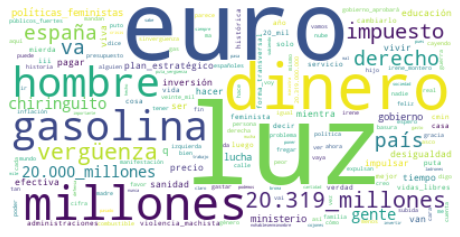

0.8218131065368652


In [47]:
start = time.time()

plot_world_cloud(com_1_phrases)    
    
end = time.time()
print(end - start)

**Detecció temàtiques amb LDA**

In [131]:
start = time.time()

com_1_modelsLDA, com_1_coherences = get_modelsLDA_and_coherences(com_1_phrases, 10, 10)

end = time.time()
print(end - start)

367.7707288265228


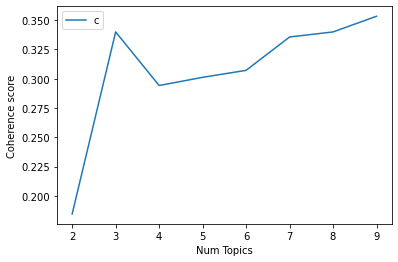

In [132]:
plot_coherences(com_1_coherences, 10)

Provem amb k=3, k=7 i k=9.

In [179]:
plot_pyLDAvis(com_1_phrases, com_1_modelsLDA[1])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.125171  0.222708       1        1  50.627649
0     -0.284540 -0.017157       2        1  25.608304
1      0.159369 -0.205551       3        1  23.764047, topic_info=           Term         Freq        Total Category  logprob  loglift
55         euro  2020.000000  2020.000000  Default  30.0000  30.0000
143   vergüenza  1456.000000  1456.000000  Default  29.0000  29.0000
59     millones  1482.000000  1482.000000  Default  28.0000  28.0000
106         luz  1942.000000  1942.000000  Default  27.0000  27.0000
103    gasolina  1320.000000  1320.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
249      hombre   136.726235  1431.646726   Topic3  -5.9542  -0.9116
324    gobierno   118.944808   875.604343   Topic3  -6.0935  -0.5593
1720      igual   100.778408   246.232822   Topic3  -6.2593   0.5436
112        bien   102.159292   448.651122   Topic3  -6.2457  -0.0427
501       menos    96.856157   446.385453   Topic3  -6.2990  -0.0910

[162 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
95        2  0.997493                2
560       1  0.622262  20.000_millones
560       2  0.378185  20.000_millones
770       2  0.996158   20.319.000.000
96        2  0.999853  20.319_millones
...     ...       ...              ...
34        2  0.999723            vivir
3542      3  0.990388           votado
3703      3  0.987480            votar
94        3  0.996496              vox
1544      1  0.994632              voy

[171 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

In [180]:
plot_pyLDAvis(com_1_phrases, com_1_modelsLDA[5])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.364986 -0.007692       1        1  20.612292
2      0.063971 -0.189965       2        1  20.054122
3     -0.063222  0.001962       3        1  13.822241
1      0.089396 -0.069627       4        1  13.805548
4      0.104968 -0.126528       5        1  13.241022
6      0.102661  0.074410       6        1  12.131309
5      0.067211  0.317440       7        1   6.333467, topic_info=                 Term         Freq        Total Category  logprob  loglift
106               luz  1877.000000  1877.000000  Default  30.0000  30.0000
59           millones  1475.000000  1475.000000  Default  29.0000  29.0000
55               euro  1953.000000  1953.000000  Default  28.0000  28.0000
103          gasolina  1266.000000  1266.000000  Default  27.0000  27.0000
96    20.319_millones  1240.000000  1240.000000  Default  26.0000  26.0000
...               ...          ...          ...      ...      ...      ...
3378             dijo    34.941000    35.723285   Topic7  -5.9962   2.7372
2703          acritud    32.486935    33.274513   Topic7  -6.0690   2.7354
27           derechos   633.231020   661.641178   Topic7  -3.0990   2.7154
21              lucha   625.874568   700.818262   Topic7  -3.1107   2.6462
2420            mucha    53.025665    76.043672   Topic7  -5.5791   2.3988

[357 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
659       1  0.345682                 1
659       3  0.619346                 1
659       4  0.033608                 1
637       3  0.994398           120.000
95        1  0.832381                 2
...     ...       ...               ...
94        4  0.803396               vox
94        6  0.190906               vox
1544      2  0.996343               voy
1358      6  0.987782  wecallitigualdad
639       3  0.991344            ángela

[463 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2, 5, 7, 6])

In [181]:
plot_pyLDAvis(com_1_phrases, com_1_modelsLDA[7])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.178607 -0.289839       1        1  18.084723
7     -0.160022  0.187547       2        1  17.884822
3     -0.201549  0.046214       3        1  13.580668
2     -0.109496  0.125216       4        1  11.699334
6      0.068826  0.029991       5        1  10.153933
8      0.062473 -0.176109       6        1   8.435229
1      0.149044  0.081292       7        1   8.216285
4      0.161083  0.021438       8        1   6.563122
5      0.208247 -0.025750       9        1   5.381884, topic_info=           Term         Freq        Total Category  logprob  loglift
143   vergüenza  1469.000000  1469.000000  Default  30.0000  30.0000
59     millones  1564.000000  1564.000000  Default  29.0000  29.0000
106         luz  1963.000000  1963.000000  Default  28.0000  28.0000
55         euro  2030.000000  2030.000000  Default  27.0000  27.0000
76            q   997.000000   997.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
21        lucha   629.236183   712.951170   Topic9  -2.9426   2.7972
27     derechos   550.419503   673.414850   Topic9  -3.0764   2.7205
1427      haces    51.240524    73.882399   Topic9  -5.4505   2.5562
689      hambre    77.266229   182.961213   Topic9  -5.0398   2.0601
18       españa   158.969759  1171.240402   Topic9  -4.3184   0.9250

[450 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
659       1  0.246399                 1
659       3  0.661626                 1
659       8  0.086696                 1
637       4  0.993871           120.000
95        1  0.563139                 2
...     ...       ...               ...
2754      5  0.982988           we_call
1358      5  0.988825  wecallitigualdad
5469      9  0.984269                xd
7139      3  0.981237         youtubers
639       4  0.990804            ángela

[611 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 8, 4, 3, 7, 9, 2, 5, 6])

In [182]:
pprint(com_1_modelsLDA[1].print_topics()) 

[(0,
  '0.036*"euro" + 0.028*"luz" + 0.026*"millones" + 0.023*"gasolina" + '
  '0.023*"20.319_millones" + 0.016*"hombre" + 0.016*"políticas_feministas" + '
  '0.014*"educación" + 0.014*"sanidad" + 0.013*"inversión"'),
 (1,
  '0.028*"vergüenza" + 0.011*"decir" + 0.009*"casa" + 0.008*"izquierda" + '
  '0.006*"fregar" + 0.006*"derechas" + 0.005*"mandan" + 0.005*"expulsan" + '
  '0.004*"feminista" + 0.004*"ministra"'),
 (2,
  '0.018*"dinero" + 0.009*"españa" + 0.009*"q" + 0.008*"va" + '
  '0.007*"impuestos" + 0.007*"gobierno" + 0.007*"país" + 0.006*"gente" + '
  '0.006*"van" + 0.005*"ministerio"')]


In [183]:
pprint(com_1_modelsLDA[5].print_topics()) 

[(0,
  '0.041*"luz" + 0.033*"euro" + 0.028*"gasolina" + 0.027*"20.319_millones" + '
  '0.026*"vergüenza" + 0.020*"hombre" + 0.019*"políticas_feministas" + '
  '0.016*"inversión" + 0.015*"impulsar" + 0.015*"forma_transversal"'),
 (1,
  '0.013*"gobierno" + 0.012*"dinero" + 0.011*"ministerio" + 0.009*"bien" + '
  '0.008*"vergüenza" + 0.008*"feminista" + 0.007*"ministra" + 0.006*"da" + '
  '0.006*"broma" + 0.006*"cara"'),
 (2,
  '0.022*"q" + 0.017*"dinero" + 0.013*"va" + 0.010*"van" + 0.008*"hacer" + '
  '0.008*"luego" + 0.008*"españa" + 0.008*"gente" + 0.007*"gastar" + '
  '0.007*"país"'),
 (3,
  '0.048*"millones" + 0.025*"educación" + 0.025*"sanidad" + 0.024*"impuestos" '
  '+ 0.016*"españa" + 0.015*"20_mil" + 0.014*"euro" + 0.014*"puta" + '
  '0.013*"presupuesto" + 0.012*"hijos"'),
 (4,
  '0.026*"dinero" + 0.013*"cayendo" + 0.012*"parece" + 0.010*"asco" + '
  '0.009*"crisis" + 0.008*"va" + 0.008*"mierda" + 0.007*"vaya" + '
  '0.007*"puta_vergüenza" + 0.007*"invertir"'),
 (5,
  '0.045*"d

In [184]:
pprint(com_1_modelsLDA[7].print_topics()) 

[(0,
  '0.045*"luz" + 0.039*"euro" + 0.030*"gasolina" + 0.029*"20.319_millones" + '
  '0.022*"hombre" + 0.021*"políticas_feministas" + 0.019*"inversión" + '
  '0.018*"impulsar" + 0.018*"forma_transversal" + 0.018*"plan_estratégico"'),
 (1,
  '0.081*"vergüenza" + 0.031*"decir" + 0.026*"casa" + 0.022*"izquierda" + '
  '0.018*"fregar" + 0.017*"derechas" + 0.015*"mandan" + 0.015*"expulsan" + '
  '0.010*"broma" + 0.010*"da"'),
 (2,
  '0.038*"q" + 0.011*"digo" + 0.010*"chiringuito" + 0.010*"impuestos" + '
  '0.009*"españa" + 0.009*"crisis" + 0.008*"puta_vergüenza" + '
  '0.008*"irene_montero" + 0.008*"ma" + 0.008*"feminista"'),
 (3,
  '0.052*"millones" + 0.027*"educación" + 0.027*"sanidad" + 0.020*"impuestos" '
  '+ 0.017*"dinero" + 0.016*"20_mil" + 0.016*"euro" + 0.015*"puta" + '
  '0.014*"van" + 0.014*"presupuesto"'),
 (4,
  '0.011*"asco" + 0.011*"mierda" + 0.009*"dios" + 0.008*"elecciones" + '
  '0.008*"justicia" + 0.008*"cárcel" + 0.006*"amigo" + 0.006*"feliz" + '
  '0.006*"entrar" + 0.0

Amb k=7 i k=9 tenim molts temes que fan referència als diners gastats en les polítiques d'igualtat, així que elegim k=3 per no repetir tant els temes.

### Comunitat 2

**Obtenció dels missatges**

In [29]:
nodes_com_2 = get_nicknames(G, 2)
len(nodes_com_2)

10049

In [30]:
start = time.time()
tweets_com_2 = get_tweets(nodes_com_2, db)

end = time.time()
print(end - start)

17184.502058267593


In [31]:
len(tweets_com_2)

38009

In [32]:
f = open('tweets/tweets_comunitats/com_2_tweets.txt', 'w', encoding='utf-8')

for tweet in tweets_com_2:
    f.write(tweet.replace('\n', ' ')+'\n')
        
f.close()

In [37]:
with open('tweets/tweets_comunitats/com_2_tweets.txt', 'r', encoding='utf-8') as f:
    com_2_tweets = f.readlines()
    print(com_2_tweets[0:5])

['Todos los derechos para todas las mujeres. Vidas libres de violencia machista, con tiempo para vivir, con servicios públicos fuertes, sin desigualdad.   Feminismo para todas y para cambiarlo todo.   Que viva la lucha de las mujeres #8M\n', 'El #8M celebramos a las que pelearon antes que nosotras por los derechos que hoy disfrutamos y seguimos peleando por los derechos que disfrutarán las que nos seguirán. Celebramos un #FeminismoParaSerMejores.   Hoy y siempre, que viva la lucha de las mujeres.\n', '¿Qué pasa cuando las mujeres recuperamos los espacios y las palabras que hemos dejado de decir? 🤔   En esta 💊 #VitaminaFeminista os explico por qué silenciar no es solo ‘mandar callar’, sino también infravalorar nuestras experiencias o apropiarse de nuestras ideas.    #8M 👇 https://t.co/bcBlNtXOlU\n', 'Construyendo sociedades y vidas dignas de ser vividas. Feminismo para acompañarlo todo. En Latinoamérica, en África, en Europa y en todo el mundo.  Que viva la lucha internacional de las mu

Comprovem.

In [38]:
len(com_2_tweets)

38009

**Preparació del text**

In [39]:
start = time.time()

com_2_clean_tweets = clean_tweets(com_2_tweets)

end = time.time()
print(end - start)

0.661522388458252


Comprovem.

In [40]:
com_2_clean_tweets[0:3]

['Todos los derechos para todas las mujeres. Vidas libres de violencia machista  con tiempo para vivir  con servicios públicos fuertes  sin desigualdad.   Feminismo para todas y para cambiarlo todo.   Que viva la lucha de las mujeres  8M ',
 'El itemDeleted celebramos a las que pelearon antes que nosotras por los derechos que hoy disfrutamos y seguimos peleando por los derechos que disfrutarán las que nos seguirán. Celebramos un  FeminismoParaSerMejores.   Hoy y siempre  que viva la lucha de las mujeres. ',
 ' Qué pasa cuando las mujeres recuperamos los espacios y las palabras que hemos dejado de decir      En esta itemDeleted   VitaminaFeminista os explico por qué silenciar no es solo  mandar callar   sino también infravalorar nuestras experiencias o apropiarse de nuestras ideas.    itemDeleted itemDeleted  itemDeleted  ']

In [41]:
start = time.time()

com_2_model_phrases = create_phrases_model(com_2_clean_tweets)

end = time.time()
print(end - start)

8.46514105796814


Comprovem.

In [42]:
com_2_model_phrases

In [43]:
start = time.time()

com_2_phrases = [get_phrases_filtered_lemmatized(s, com_2_model_phrases, stopwords) for s in com_2_clean_tweets]

end = time.time()
print(end - start)

16.610440015792847


Comprovem.

In [44]:
com_2_phrases[0:3]

[['derechos',
  'vidas_libres',
  'violencia_machista',
  'tiempo',
  'vivir',
  'servicios_públicos',
  'fuertes',
  'desigualdad',
  'cambiarlo',
  'viva',
  'lucha'],
 ['celebramos',
  'pelearon',
  'derechos',
  'disfrutamos',
  'seguimos_peleando',
  'derechos',
  'disfrutarán',
  'seguirán',
  'celebramos',
  'feminismoparasermejores',
  'siempre',
  'viva',
  'lucha'],
 ['pasa',
  'recuperamos',
  'espacios',
  'palabras',
  'dejado',
  'decir',
  'vitaminafeminista',
  'explico',
  'silenciar',
  'solo_mandar',
  'callar_sino',
  'infravalorar',
  'experiencias',
  'apropiarse',
  'idea']]

**Creació del núvol de paraules**

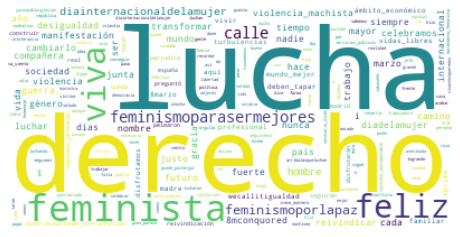

1.082106113433838


In [57]:
start = time.time()

plot_world_cloud(com_2_phrases)    
    
end = time.time()
print(end - start)

**Detecció temàtiques amb LDA**

In [133]:
start = time.time()

com_2_modelsLDA, com_2_coherences = get_modelsLDA_and_coherences(com_2_phrases, 10, 10)

end = time.time()
print(end - start)

455.08995604515076


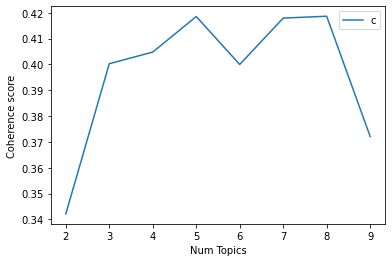

In [134]:
plot_coherences(com_2_coherences, 10)

In [188]:
plot_pyLDAvis(com_2_phrases, com_2_modelsLDA[1])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.251476  0.146767       1        1  37.629299
0      0.004012 -0.286726       2        1  33.990643
1     -0.255489  0.139959       3        1  28.380058, topic_info=               Term         Freq        Total Category  logprob  loglift
38    internacional  2613.000000  2613.000000  Default  30.0000  30.0000
110             ser  2483.000000  2483.000000  Default  29.0000  29.0000
1127          puede  1948.000000  1948.000000  Default  28.0000  28.0000
37            feliz  3392.000000  3392.000000  Default  27.0000  27.0000
3154  participación  1540.000000  1540.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
4             lucha  1524.019637  4577.292230   Topic3  -4.1719   0.1597
18          siempre   721.829315  1557.420049   Topic3  -4.9192   0.4905
0         cambiarlo   451.255175   803.733078   Topic3  -5.3890   0.6822
114          calles   460.640123  1556.069650   Topic3  -5.3684   0.0422
2       desigualdad   436.053115  1205.163394   Topic3  -5.4232   0.2429

[166 rows x 6 columns], token_table=      Topic      Freq                Term
term                                     
7053      2  0.998421        2022_horario
407       1  0.133898                   8
407       2  0.865609                   8
4356      2  0.998433                 8_m
898       1  0.485994       8mitemdeleted
...     ...       ...                 ...
9         3  0.536528                viva
10        3  0.998660               vivir
547       1  0.999070    wecallitigualdad
1081      3  0.998807  yoconpabloiglesias
4116      2  0.999099             íntegro

[180 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

In [189]:
plot_pyLDAvis(com_2_phrases, com_2_modelsLDA[3])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.226895  0.213814       1        1  22.048737
4     -0.006757 -0.190280       2        1  21.423639
1      0.325669  0.116072       3        1  20.335945
0     -0.055748 -0.223998       4        1  18.588172
3     -0.036268  0.084392       5        1  17.603509, topic_info=                           Term         Freq        Total Category  logprob  \
37                        feliz  4239.000000  4239.000000  Default  30.0000   
38                internacional  2688.000000  2688.000000  Default  29.0000   
1127                      puede  1763.000000  1763.000000  Default  28.0000   
110                         ser  2253.000000  2253.000000  Default  27.0000   
3154              participación  1548.000000  1548.000000  Default  26.0000   
...                         ...          ...          ...      ...      ...   
589                       mejor   275.930696   394.996206   Topic5  -5.4032   
438                        país   360.006809  1532.025317   Topic5  -5.1373   
286   diainternacionaldelamujer   321.457659  1425.404331   Topic5  -5.2505   
283           feminismoporlapaz   299.775842  1396.997052   Topic5  -5.3204   
58                   feministas   279.009567  1379.694699   Topic5  -5.3922   

      loglift  
37    30.0000  
38    29.0000  
1127  28.0000  
110   27.0000  
3154  26.0000  
...       ...  
589    1.3783  
438    0.2888  
286    0.2477  
283    0.1980  
58     0.1387  

[254 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
2845      5  0.996731               ...
2846      5  0.998554    .._diferencias
597       4  0.995017              1975
7053      2  0.999514      2022_horario
407       2  0.114490                 8
...     ...       ...               ...
1906      3  0.599876           youtube
56        1  0.999182  ámbito_económico
249       4  0.996653             ánimo
1363      3  0.994329                és
4116      4  0.999350           íntegro

[309 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 2, 1, 4])

In [190]:
plot_pyLDAvis(com_2_phrases, com_2_modelsLDA[5])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.270830 -0.058245       1        1  16.687988
5      0.085839  0.167658       2        1  16.118569
4     -0.066740  0.070405       3        1  15.409419
0      0.204632  0.177349       4        1  13.456655
3     -0.059443 -0.002915       5        1  13.047176
6     -0.098615 -0.035373       6        1  12.987949
1      0.205157 -0.318879       7        1  12.292244, topic_info=                         Term         Freq        Total Category  logprob  \
37                      feliz  4704.000000  4704.000000  Default  30.0000   
38              internacional  2076.000000  2076.000000  Default  29.0000   
14    feminismoparasermejores  1945.000000  1945.000000  Default  28.0000   
1127                    puede  1412.000000  1412.000000  Default  27.0000   
1                    derechos  4516.000000  4516.000000  Default  26.0000   
...                       ...          ...          ...      ...      ...   
898             8mitemdeleted   644.609529  1281.100004   Topic7  -4.1956   
18                    siempre   734.253862  1561.582455   Topic7  -4.0654   
283         feminismoporlapaz   499.839131  1358.236096   Topic7  -4.4500   
1419                 labase8m   274.125585   461.609496   Topic7  -5.0507   
4                       lucha   389.514856  4446.445402   Topic7  -4.6994   

      loglift  
37    30.0000  
38    29.0000  
14    28.0000  
1127  27.0000  
1     26.0000  
...       ...  
898    1.4094  
18     1.3416  
283    1.0965  
1419   1.5751  
4     -0.3388  

[347 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
2845      5  0.996965               ...
2846      5  0.995227    .._diferencias
597       4  0.993448              1975
565       2  0.993424   20.319_millones
7053      4  0.999222      2022_horario
...     ...       ...               ...
56        1  0.998942  ámbito_económico
249       4  0.994277             ánimo
1363      2  0.996786                és
4116      4  0.997820           íntegro
228       6  0.997881           últimos

[476 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 5, 1, 4, 7, 2])

In [191]:
plot_pyLDAvis(com_2_phrases, com_2_modelsLDA[6])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.019729 -0.195740       1        1  15.463319
4     -0.172652 -0.036296       2        1  13.707956
0      0.121752  0.331946       3        1  13.184456
7     -0.267493  0.087582       4        1  13.107517
3     -0.024113 -0.079063       5        1  12.565273
5     -0.008427  0.058920       6        1  11.876077
6      0.146573 -0.115784       7        1  10.098430
1      0.224090 -0.051565       8        1   9.996972, topic_info=                         Term         Freq        Total Category  logprob  \
37                      feliz  4824.000000  4824.000000  Default  30.0000   
38              internacional  2167.000000  2167.000000  Default  29.0000   
14    feminismoparasermejores  2024.000000  2024.000000  Default  28.0000   
1127                    puede  1367.000000  1367.000000  Default  27.0000   
110                       ser  1913.000000  1913.000000  Default  26.0000   
...                       ...          ...          ...      ...      ...   
4                       lucha   324.315169  4863.860061   Topic8  -4.6759   
462                    españa   192.762934  1002.489932   Topic8  -5.1961   
772               patriarcado   159.147832   322.078421   Topic8  -5.3877   
8          violencia_machista   161.105255   836.239135   Topic8  -5.3755   
174                      aquí   152.944281   561.130995   Topic8  -5.4275   

      loglift  
37    30.0000  
38    29.0000  
14    28.0000  
1127  27.0000  
110   26.0000  
...       ...  
4     -0.4050  
462    0.6541  
772    1.5979  
8      0.6560  
174    1.0030  

[382 rows x 6 columns], token_table=      Topic      Freq                Term
term                                     
2845      5  0.997657                 ...
2846      5  0.995457      .._diferencias
597       3  0.988478                1975
565       6  0.996906     20.319_millones
7053      3  0.998490        2022_horario
...     ...       ...                 ...
1081      4  0.998385  yoconpabloiglesias
56        7  0.998762    ámbito_económico
249       6  0.996479               ánimo
1363      6  0.994902                  és
4116      3  0.999190             íntegro

[507 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 1, 8, 4, 6, 7, 2])

In [192]:
pprint(com_2_modelsLDA[1].print_topics()) 

[(0,
  '0.025*"feliz" + 0.022*"internacional" + 0.019*"lucha" + 0.015*"feminista" + '
  '0.013*"participación" + 0.009*"8" + 0.009*"sociedad" + 0.009*"hombre" + '
  '0.008*"marzo" + 0.008*"diainternacionaldelamujer"'),
 (1,
  '0.024*"ser" + 0.020*"puede" + 0.015*"lucha" + 0.015*"derechos" + '
  '0.013*"hombre" + 0.012*"feminismoporlapaz" + 0.011*"viva" + 0.010*"tan" + '
  '0.009*"feminismoparasermejores" + 0.009*"alguien"'),
 (2,
  '0.017*"derechos" + 0.013*"junta" + 0.012*"aborto" + 0.011*"país" + '
  '0.011*"cada" + 0.010*"nadie" + 0.010*"futuro" + 0.010*"transformar" + '
  '0.009*"wecallitigualdad" + 0.009*"guerra"')]


In [193]:
pprint(com_2_modelsLDA[3].print_topics()) 

[(0,
  '0.034*"internacional" + 0.024*"lucha" + 0.024*"participación" + '
  '0.018*"sociedad" + 0.017*"hombre" + 0.015*"marzo" + 0.015*"verdad" + '
  '0.015*"8" + 0.014*"trabajadora" + 0.013*"historia"'),
 (1,
  '0.028*"ser" + 0.025*"puede" + 0.014*"hombre" + 0.012*"tan" + 0.012*"i" + '
  '0.012*"alguien" + 0.011*"amy_winehouse" + 0.011*"love_is" + '
  '0.011*"losing_game" + 0.011*"rodearon"'),
 (2,
  '0.020*"derechos" + 0.018*"aborto" + 0.018*"junta" + 0.017*"cada" + '
  '0.015*"nadie" + 0.015*"futuro" + 0.014*"país" + 0.014*"transformar" + '
  '0.013*"wecallitigualdad" + 0.013*"construir"'),
 (3,
  '0.063*"feliz" + 0.026*"feminismoparasermejores" + 0.020*"derechos" + '
  '0.019*"movimiento_feminista" + 0.017*"culpa" + 0.016*"subnormal" + '
  '0.016*"pandemia" + 0.015*"volcán" + 0.013*"siempre" + 0.013*"celebramos"'),
 (4,
  '0.020*"lucha" + 0.017*"derechos" + 0.017*"viva" + 0.017*"feminista" + '
  '0.016*"calles" + 0.012*"mundo" + 0.012*"manifestaciones" + '
  '0.012*"feministas" + 0

In [194]:
pprint(com_2_modelsLDA[5].print_topics()) 

[(0,
  '0.042*"internacional" + 0.026*"participación" + 0.024*"lucha" + '
  '0.017*"marzo" + 0.017*"8" + 0.017*"hombre" + 0.016*"verdad" + '
  '0.015*"trabajadora" + 0.013*"sociedad" + 0.013*"pie"'),
 (1,
  '0.033*"puede" + 0.031*"ser" + 0.030*"aborto" + 0.022*"españa" + '
  '0.017*"siempre" + 0.015*"defensora" + 0.015*"alguien" + 0.015*"artículo" + '
  '0.015*"interseccional" + 0.015*"cariño"'),
 (2,
  '0.028*"derechos" + 0.022*"cada" + 0.022*"junta" + 0.022*"futuro" + '
  '0.021*"nadie" + 0.020*"país" + 0.020*"wecallitigualdad" + 0.019*"realidad" '
  '+ 0.019*"construir" + 0.019*"sabemos"'),
 (3,
  '0.096*"feliz" + 0.037*"feminismoparasermejores" + 0.032*"derechos" + '
  '0.019*"celebramos" + 0.018*"siempre" + 0.015*"lucha" + 0.011*"viva" + '
  '0.011*"país" + 0.011*"necesario_dicen" + 0.010*"gracias"'),
 (4,
  '0.019*"calles" + 0.017*"manifestaciones" + 0.017*"movimiento_feminista" + '
  '0.017*"pandemia" + 0.017*"derechos" + 0.017*"ciudades" + 0.016*"ucrania" + '
  '0.016*"manifest

In [195]:
pprint(com_2_modelsLDA[6].print_topics()) 

[(0,
  '0.042*"internacional" + 0.027*"participación" + 0.019*"lucha" + '
  '0.015*"trabajadora" + 0.014*"especial" + 0.014*"pie" + 0.014*"culpa" + '
  '0.014*"i" + 0.014*"jornada" + 0.014*"historia"'),
 (1,
  '0.040*"ser" + 0.039*"puede" + 0.036*"aborto" + 0.019*"siempre" + '
  '0.018*"8mitemdeleted" + 0.018*"defensora" + 0.018*"alguien" + '
  '0.018*"artículo" + 0.018*"interseccional" + 0.018*"cariño"'),
 (2,
  '0.026*"guerra" + 0.021*"ucrania" + 0.018*"tan" + 0.018*"subnormal" + '
  '0.017*"separado" + 0.012*"nunca" + 0.011*"derechos" + '
  '0.009*"diainternacionaldelamujer" + 0.008*"necesario" + 0.008*"dice"'),
 (3,
  '0.101*"feliz" + 0.042*"feminismoparasermejores" + 0.028*"derechos" + '
  '0.025*"8_m" + 0.020*"celebramos" + 0.019*"siempre" + 0.016*"lucha" + '
  '0.011*"viva" + 0.011*"diainternacionaldelamujer" + 0.010*"país"'),
 (4,
  '0.020*"manifestaciones" + 0.020*"pandemia" + 0.020*"calles" + '
  '0.020*"movimiento_feminista" + 0.020*"ciudades" + 0.019*"derechos" + '
  '0.019

Veient la coherència i els gràfics de gemsimvis elegim k=8.

### Comunitat 3

**Obtenció dels missatges**

In [33]:
nodes_com_3 = get_nicknames(G, 3)
len(nodes_com_3)

5866

In [34]:
start = time.time()
tweets_com_3 = get_tweets(nodes_com_3, db)

end = time.time()
print(end - start)

10027.429754257202


In [35]:
len(tweets_com_3)

23401

In [36]:
f = open('tweets/tweets_comunitats/com_3_tweets.txt', 'w', encoding='utf-8')

for tweet in tweets_com_3:
    f.write(tweet.replace('\n', ' ')+'\n')
        
f.close()

In [343]:
with open('tweets/tweets_comunitats/com_3_tweets.txt', 'r', encoding='utf-8') as f:
    com_3_tweets = f.readlines()
    print(com_3_tweets[0:5])

['💜 ¡Viva el 8 de marzo!  💜 ¡Viva la lucha de las mujeres!  Frente a quienes menosprecian el feminismo, seguimos avanzando en la conquista y defensa de derechos de las mujeres.   JUNTAS. ✊🏽   🙋🏻\u200d♀️ Este #8M: #MásFeminismoMejorDemocracia https://t.co/zMedK2Fo84\n', 'Aún queda camino por recorrer para alcanzar la igualdad real y plena, y es algo irrenunciable. Las niñas y las mujeres deben ocupar los espacios que les corresponden. Ellas, las más pequeñas, deben crecer sin estereotipos y con libertad.  💜 ¡Que viva la lucha de las mujeres! #8M https://t.co/588iVfWEkV\n', "🟣 'Nosotras jugamos, nosotras elegimos'  Este #8M desde el Gobierno de #Canarias reivindicamos una infancia sin estereotipos y el derecho de las niñas a jugar libres y sin imposiciones. Juegos y educación no sexistas para romper los roles de género https://t.co/mL3eCSxNEo\n", 'La prostitución es una forma de violencia contra las mujeres.  ➡️ Su abolición es un compromiso del presidente @sanchezcastejon y uno de los p

Comprovem.

In [243]:
len(com_3_tweets)

23401

**Preparació del text**

In [287]:
start = time.time()

com_3_clean_tweets = clean_tweets(com_3_tweets)

end = time.time()
print(end - start)

0.4976921081542969


Comprovem.

In [50]:
com_3_clean_tweets[0:3]

['itemDeleted   Viva el 8 de marzo   itemDeleted   Viva la lucha de las mujeres   Frente a quienes menosprecian el feminismo  seguimos avanzando en la conquista y defensa de derechos de las mujeres.   JUNTAS.  itemDeleted    itemDeleted     Este  8M   MásFeminismoMejorDemocracia itemDeleted  ',
 'Aún queda camino por recorrer para alcanzar la igualdad real y plena  y es algo irrenunciable. Las niñas y las mujeres deben ocupar los espacios que les corresponden. Ellas  las más pequeñas  deben crecer sin estereotipos y con libertad.  itemDeleted   Que viva la lucha de las mujeres  itemDeleted itemDeleted  ',
 '   Nosotras jugamos  nosotras elegimos   Este itemDeleted desde el Gobierno de  Canarias reivindicamos una infancia sin estereotipos y el derecho de las niñas a jugar libres y sin imposiciones. Juegos y educación no sexistas para romper los roles de género itemDeleted  ']

In [288]:
start = time.time()

com_3_model_phrases = create_phrases_model(com_3_clean_tweets)

end = time.time()
print(end - start)

6.032424211502075


Comprovem.

In [52]:
com_3_model_phrases

In [289]:
start = time.time()

com_3_phrases = [get_phrases_filtered_lemmatized(s, com_3_model_phrases, stopwords) for s in com_3_clean_tweets]

end = time.time()
print(end - start)

12.013846397399902


Comprovem.

In [54]:
com_3_phrases[0:3]

[['viva',
  '8',
  'marzo',
  'viva',
  'lucha',
  'frente',
  'menosprecian',
  'seguimos_avanzando',
  'conquista',
  'defensa',
  'derechos',
  'junta',
  'másfeminismomejordemocracia'],
 ['aún_queda',
  'camino',
  'recorrer',
  'alcanzar',
  'real',
  'plenum',
  'irrenunciable',
  'niñas',
  'deben_ocupar',
  'espacios',
  'corresponden',
  'pequeñas',
  'deben_crecer',
  'estereotipos',
  'libertad',
  'viva',
  'lucha'],
 ['jugamos',
  'elegimos',
  'gobierno',
  'canarias_reivindicamos',
  'infancia',
  'estereotipos',
  'derecho',
  'niñas',
  'jugar_libres',
  'imposiciones',
  'juegos',
  'educación',
  'sexistas',
  'romper',
  'role',
  'género']]

**Creació del núvol de paraules**

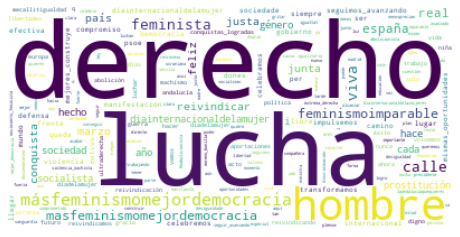

1.0422112941741943


In [71]:
start = time.time()

plot_world_cloud(com_3_phrases)    
    
end = time.time()
print(end - start)

**Detecció temàtiques amb LDA**

In [290]:
start = time.time()

com_3_modelsLDA, com_3_coherences = get_modelsLDA_and_coherences(com_3_phrases, 10, 10)

end = time.time()
print(end - start)

378.1072726249695


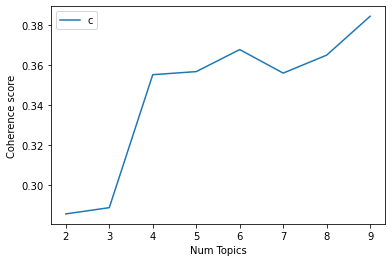

In [291]:
plot_coherences(com_3_coherences, 10)

In [314]:
plot_pyLDAvis(com_3_phrases, com_3_modelsLDA[4])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.084200 -0.032604       1        1  20.618974
5     -0.359369  0.109033       2        1  16.550951
1      0.150672  0.158532       3        1  16.307362
3      0.126009  0.145858       4        1  16.109801
2      0.004340 -0.251789       5        1  15.295004
0     -0.005852 -0.129030       6        1  15.117909, topic_info=                             Term         Freq        Total Category  logprob  \
11                           viva  1681.000000  1681.000000  Default  30.0000   
333                         feliz   985.000000   985.000000  Default  29.0000   
3                        derechos  3273.000000  3273.000000  Default  28.0000   
6                           lucha  2843.000000  2843.000000  Default  27.0000   
99                         españa  1329.000000  1329.000000  Default  26.0000   
...                           ...          ...          ...      ...      ...   
32                         género   179.961956   861.303397   Topic6  -5.3653   
103   masfeminismomejordemocracia   192.683917  1557.386270   Topic6  -5.2970   
6                           lucha   206.608565  2843.456562   Topic6  -5.2272   
1116             wecallitigualdad   150.872951   440.019061   Topic6  -5.5416   
304                    democracia   135.764085   557.932772   Topic6  -5.6471   

      loglift  
11    30.0000  
333   29.0000  
3     28.0000  
6     27.0000  
99    26.0000  
...       ...  
32     0.3236  
103   -0.2004  
6     -0.7327  
1116   0.8189  
304    0.4760  

[368 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
576       3  0.986756              2022
5389      1  0.995895             2025.
0         3  0.395136                 8
0         4  0.604440                 8
350       1  0.683912            8marzo
...     ...       ...               ...
1116      4  0.152266  wecallitigualdad
1116      5  0.034089  wecallitigualdad
1116      6  0.343167  wecallitigualdad
3579      2  0.995247                és
105       4  0.998863            éxitos

[507 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 2, 4, 3, 1])

In [321]:
plot_pyLDAvis(com_3_phrases, com_3_modelsLDA[6])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.088310 -0.031200       1        1  18.320885
1      0.175626  0.188191       2        1  13.960302
6     -0.361980  0.166158       3        1  13.173019
3      0.155043  0.157252       4        1  12.519499
5      0.000709 -0.184133       5        1  11.053878
0     -0.025263 -0.109484       6        1  10.467361
2     -0.027622 -0.084780       7        1  10.374372
7     -0.004824 -0.102005       8        1  10.130683, topic_info=              Term         Freq        Total Category  logprob  loglift
11            viva  1709.000000  1709.000000  Default  30.0000  30.0000
104           país   989.000000   989.000000  Default  29.0000  29.0000
333          feliz  1006.000000  1006.000000  Default  28.0000  28.0000
6            lucha  2878.000000  2878.000000  Default  27.0000  27.0000
99          españa  1357.000000  1357.000000  Default  26.0000  26.0000
..             ...          ...          ...      ...      ...      ...
233    socialistas   164.405948   853.791970   Topic8  -5.0554   0.6423
326        momento    99.771015   160.807118   Topic8  -5.5548   1.8123
195         calles   165.860116  1509.043422   Topic8  -5.0465   0.0815
200       volvemos   119.410691   358.536083   Topic8  -5.3751   1.1901
199  reivindicamos   116.004411   400.804813   Topic8  -5.4041   1.0498

[476 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
5440      5  0.981194  20.319_millones
5389      1  0.990827            2025.
0         2  0.392584                8
0         4  0.606547                8
350       1  0.681945           8marzo
...     ...       ...              ...
786       7  0.988501           vuelto
409       7  0.989632         vulneren
3579      3  0.994299               és
105       4  0.997364           éxitos
2702      5  0.990989     único_camino

[730 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 7, 4, 6, 1, 3, 8])

In [317]:
plot_pyLDAvis(com_3_phrases, com_3_modelsLDA[7])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.131417 -0.094340       1        1  16.912853
1     -0.160804  0.233106       2        1  12.203114
8     -0.116123 -0.093151       3        1  11.950817
5      0.367797  0.113715       4        1  11.561256
3     -0.101710  0.193050       5        1  11.404313
6      0.070920 -0.087303       6        1  10.259762
7      0.019523 -0.017856       7        1   8.667596
0      0.064350 -0.058250       8        1   8.533670
2     -0.012537 -0.188971       9        1   8.506620, topic_info=                           Term         Freq        Total Category  logprob  \
11                         viva  1750.000000  1750.000000  Default  30.0000   
104                        país   988.000000   988.000000  Default  29.0000   
6                         lucha  2926.000000  2926.000000  Default  28.0000   
99                       españa  1390.000000  1390.000000  Default  27.0000   
3                      derechos  3391.000000  3391.000000  Default  26.0000   
...                         ...          ...          ...      ...      ...   
3                      derechos   192.809123  3391.950489   Topic9  -4.7213   
143                         año   106.447010   474.593066   Topic9  -5.3153   
226   díainternacionaldelamujer   105.553680   745.766396   Topic9  -5.3237   
1319                    gracias    98.133170   368.690140   Topic9  -5.3966   
136                       mejor    93.675717   275.176188   Topic9  -5.4431   

      loglift  
11    30.0000  
104   29.0000  
6     28.0000  
99    27.0000  
3     26.0000  
...       ...  
3     -0.4031  
143    0.9695  
226    0.5091  
1319   1.1407  
136    1.3868  

[537 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
1066      9  0.982459      .itemdeleted
1483      1  0.176989                 1
1483      7  0.812540                 1
141       2  0.988287                19
680       4  0.604174                 2
...     ...       ...               ...
1116      9  0.022983  wecallitigualdad
3579      4  0.850135                és
3579      6  0.146882                és
105       5  0.996593            éxitos
2702      1  0.992734      único_camino

[818 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 9, 6, 4, 7, 8, 1, 3])

In [322]:
pprint(com_3_modelsLDA[4].print_topics()) 

[(0,
  '0.026*"feliz" + 0.010*"solo" + 0.008*"ser" + 0.008*"mundo" + '
  '0.008*"diainternacionaldelamujer" + 0.007*"hombre" + 0.007*"feminista" + '
  '0.007*"libertades" + 0.006*"díainternacionaldelamujer" + 0.006*"ucrania"'),
 (1,
  '0.037*"derechos" + 0.035*"viva" + 0.023*"lucha" + 0.019*"hace" + '
  '0.019*"hombre" + 0.018*"españa" + 0.016*"junta" + 0.013*"impulsemos" + '
  '0.013*"lugar" + 0.012*"justas"'),
 (2,
  '0.010*"derechos" + 0.009*"camino" + 0.009*"cada" + '
  '0.009*"diainternacionaldelamujer" + 0.008*"reivindicando" + 0.007*"motivo" '
  '+ 0.007*"masfeminismomejordemocracia" + 0.006*"socialistas" + '
  '0.005*"manifestación" + 0.005*"feminismoimparable"'),
 (3,
  '0.024*"másfeminismomejordemocracia" + 0.021*"país" + 0.017*"hecho" + '
  '0.016*"derechos" + 0.015*"8" + 0.015*"marzo" + 0.014*"españa" + '
  '0.012*"celebramos" + 0.011*"prostitución" + 0.010*"hombre"'),
 (4,
  '0.029*"lucha" + 0.019*"hombre" + 0.017*"real" + 0.015*"feminismoimparable" '
  '+ 0.015*"calles" +

In [323]:
pprint(com_3_modelsLDA[6].print_topics()) 

[(0,
  '0.034*"feliz" + 0.015*"lucha" + 0.015*"masfeminismomejordemocracia" + '
  '0.011*"feminismoimparable" + 0.010*"feminista" + 0.009*"ser" + '
  '0.009*"hombre" + 0.009*"ministra" + 0.008*"mundo" + 0.007*"solo"'),
 (1,
  '0.038*"derechos" + 0.038*"viva" + 0.023*"lucha" + 0.021*"hombre" + '
  '0.020*"españa" + 0.020*"hace" + 0.018*"másfeminismomejordemocracia" + '
  '0.017*"junta" + 0.016*"impulsemos" + 0.015*"lugar"'),
 (2,
  '0.012*"derechos" + 0.010*"calles" + 0.008*"feminismoimparable" + '
  '0.008*"masfeminismomejordemocracia" + 0.008*"siempre" + 0.008*"vamos" + '
  '0.007*"reivindicando" + 0.007*"nunca" + 0.007*"defender" + 0.007*"cada"'),
 (3,
  '0.031*"país" + 0.023*"hecho" + 0.021*"másfeminismomejordemocracia" + '
  '0.020*"8" + 0.020*"marzo" + 0.019*"españa" + 0.019*"derechos" + '
  '0.016*"celebramos" + 0.014*"libre" + 0.012*"feminista"'),
 (4,
  '0.032*"lucha" + 0.020*"hombre" + 0.018*"real" + 0.015*"feminista" + '
  '0.014*"feminismoimparable" + 0.014*"calles" + 0.014*

In [324]:
pprint(com_3_modelsLDA[7].print_topics()) 

[(0,
  '0.015*"feliz" + 0.011*"ministra" + 0.011*"feminista" + 0.009*"gobierno" + '
  '0.009*"educación" + 0.009*"societat" + 0.008*"cmin" + 0.007*"solo" + '
  '0.007*"libre" + 0.007*"género"'),
 (1,
  '0.044*"derechos" + 0.040*"viva" + 0.026*"lucha" + 0.025*"hace" + '
  '0.024*"hombre" + 0.024*"españa" + 0.019*"impulsemos" + 0.018*"lugar" + '
  '0.018*"másfeminismomejordemocracia" + 0.018*"justas"'),
 (2,
  '0.012*"motivo" + 0.010*"feminismoimparable" + 0.010*"siempre" + '
  '0.010*"vamos" + 0.009*"derechos" + 0.009*"reivindicando" + '
  '0.008*"imparable" + 0.008*"cada" + 0.008*"mismo" + '
  '0.008*"masfeminismomejordemocracia"'),
 (3,
  '0.033*"país" + 0.025*"hecho" + 0.023*"8" + '
  '0.022*"másfeminismomejordemocracia" + 0.022*"marzo" + 0.021*"españa" + '
  '0.018*"celebramos" + 0.016*"derechos" + 0.014*"conquista" + '
  '0.013*"prostitución"'),
 (4,
  '0.023*"lucha" + 0.020*"feminista" + 0.019*"derechos" + '
  '0.016*"másfeminismomejordemocracia" + 0.015*"sociedad" + 0.015*"hombre

Veient que es repeteixen alguns dels termes i l'alta coherència obtinguda amb k=6 elegirem aquest nombre de temàtiques. Per així no repetir temes en excés.

### Comunitat 4

**Obtenció dels missatges**

In [74]:
nodes_com_4 = get_nicknames(G, 4)
len(nodes_com_4)

4655

In [57]:
start = time.time()
tweets_com_4 = get_tweets(nodes_com_4, db)

end = time.time()
print(end - start)

8398.708948612213


In [58]:
len(tweets_com_4)

8621

In [59]:
f = open('tweets/tweets_comunitats/com_4_tweets.txt', 'w', encoding='utf-8')

for tweet in tweets_com_4:
    f.write(tweet.replace('\n', ' ')+'\n')
        
f.close()

In [248]:
with open('tweets/tweets_comunitats/com_4_tweets.txt', 'r', encoding='utf-8') as f:
    com_4_tweets = f.readlines()
    print(com_4_tweets[0:5])

['Hoy es el 8M día internacional de la mujer, mi opinión es que debería ser todos los días del año, reivindicación de igualdad siempre.  #8M\n', 'Mi Luisa es maravillosa y me dedica estas palabras tan bonitas por el 8M.  #8Marzo2022 #8M #8Marzo #DiaInternacionalDeLaMujer https://t.co/fcOMYArFzk\n', 'No dejaremos que nos pisen, que nos callen ni que nos hagan pequeñxs. Juntxs somos mejores. #igualdad #sororidad #hermandad #empatia #8m https://t.co/M7vju42tQQ\n', '"En Anthraganga 🇮🇳, ninguna niña ha abandonado sus estudios". 💜💜💜  #8M #8Marzo2022 #DíadelaMujer #DíaInternacionalDeLaMujer https://t.co/mRL3uW6AJ8\n', 'Para  seguir siendo valientes y seguir luchando por la igualdad, hoy y todos los días 💪🏼💪🏼💪🏼💪🏼#8M https://t.co/F1G1gOvkAf\n']


Comprovem.

In [58]:
len(com_4_tweets)

8621

**Preparació del text**

In [249]:
start = time.time()

com_4_clean_tweets = clean_tweets(com_4_tweets)

end = time.time()
print(end - start)

0.16557955741882324


Comprovem.

In [60]:
com_4_clean_tweets[0:3]

['Hoy es el 8M día internacional de la mujer  mi opinión es que debería ser todos los días del año  reivindicación de igualdad siempre.   8M ',
 'Mi Luisa es maravillosa y me dedica estas palabras tan bonitas por el 8M.  itemdeleted  itemDeleted  8Marzo  DiaInternacionalDeLaMujer itemDeleted  ',
 'No dejaremos que nos pisen  que nos callen ni que nos hagan pequeñxs. Juntxs somos mejores.  igualdad  sororidad  hermandad  empatia  8m itemDeleted  ']

In [250]:
start = time.time()

com_4_model_phrases = create_phrases_model(com_4_clean_tweets)

end = time.time()
print(end - start)

2.1063895225524902


Comprovem.

In [62]:
com_4_model_phrases

In [251]:
start = time.time()

com_4_phrases = [get_phrases_filtered_lemmatized(s, com_4_model_phrases, stopwords) for s in com_4_clean_tweets]

end = time.time()
print(end - start)

4.345919370651245


Comprovem.

In [64]:
com_4_phrases[0:3]

[['internacional',
  'opinión',
  'debería',
  'ser',
  'días',
  'año',
  'reivindicación',
  'siempre'],
 ['luisa',
  'maravillosa',
  'dedica',
  'palabras',
  'tan',
  'bonitas',
  '8marzo',
  'diainternacionaldelamujer'],
 ['dejaremos',
  'pisen',
  'callen',
  'hagan',
  'pequeñxs',
  'juntxs',
  'mejores',
  'sororidad_hermandad',
  'empatia']]

**Creació del núvol de paraules**

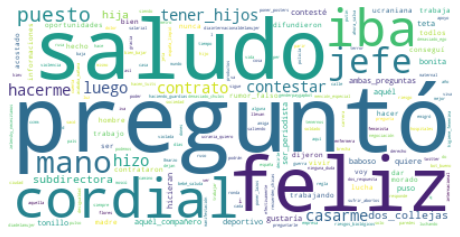

0.7071127891540527


In [82]:
start = time.time()

plot_world_cloud(com_4_phrases)    
    
end = time.time()
print(end - start)

Comprovació tweets:

In [157]:
count = 0
for tweet in com_4_tweets:
    if 'preguntó' in tweet:
        print(tweet)
        count +=1
    if count >= 10:
        break

Un saludo muy cordial al jefe que me preguntó si iba a casarme para hacerme un contrato que luego no hizo. Otro para el que me preguntó si iba a tener hijos para un puesto de subdirectora. Y dos collejas para mí por contestar a ambas preguntas. Feliz #8M

Un saludo muy cordial al jefe que me preguntó si iba a casarme para hacerme un contrato que luego no hizo. Otro para el que me preguntó si iba a tener hijos para un puesto de subdirectora. Y dos collejas para mí por contestar a ambas preguntas. Feliz #8M

Un saludo muy cordial al jefe que me preguntó si iba a casarme para hacerme un contrato que luego no hizo. Otro para el que me preguntó si iba a tener hijos para un puesto de subdirectora. Y dos collejas para mí por contestar a ambas preguntas. Feliz #8M

Un saludo muy cordial al jefe que me preguntó si iba a casarme para hacerme un contrato que luego no hizo. Otro para el que me preguntó si iba a tener hijos para un puesto de subdirectora. Y dos collejas para mí por contestar a amba

**Detecció temàtiques amb LDA**

In [252]:
start = time.time()

com_4_modelsLDA, com_4_coherences = get_modelsLDA_and_coherences(com_4_phrases, 10, 10)

end = time.time()
print(end - start)

125.11974096298218


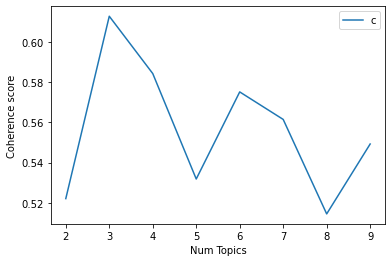

In [253]:
plot_coherences(com_4_coherences, 10)

In [292]:
plot_pyLDAvis(com_4_phrases, com_4_modelsLDA[1])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.360714  0.012330       1        1  44.307115
1     -0.164869 -0.221536       2        1  34.154478
2     -0.195846  0.209205       3        1  21.538407, topic_info=           Term         Freq        Total Category  logprob  loglift
86     preguntó  2621.000000  2621.000000  Default  30.0000  30.0000
88       saludo  1938.000000  1938.000000  Default  29.0000  29.0000
83          iba  1915.000000  1915.000000  Default  28.0000  28.0000
80        feliz  1905.000000  1905.000000  Default  27.0000  27.0000
78      cordial  1901.000000  1901.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
267       madre   441.203855   568.453880   Topic3  -3.9557   1.2819
619      guerra   231.106851   281.760048   Topic3  -4.6023   1.3372
175       hacer   235.639507   310.799270   Topic3  -4.5829   1.2585
192  ucranianas   213.318970   302.116460   Topic3  -4.6824   1.1873
139         dar   216.282451   523.595770   Topic3  -4.6686   0.6512

[141 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
611       3  0.995950              20
612       3  0.997941  acababa_mañana
613       3  0.997941     ahora_salva
614       3  0.999248          alguna
154       2  0.986216             amb
...     ...       ...             ...
61        3  0.999030           vidas
193       3  0.997450        violadas
194       3  0.996172           vivir
195       3  0.996123             voy
761       2  0.991642              és

[124 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

In [293]:
plot_pyLDAvis(com_4_phrases, com_4_modelsLDA[2])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.398474 -0.011600       1        1  40.282747
1     -0.119734 -0.012583       2        1  26.894554
2     -0.152293 -0.238868       3        1  17.054458
3     -0.126447  0.263052       4        1  15.768240, topic_info=           Term         Freq        Total Category  logprob  loglift
86     preguntó  2694.000000  2694.000000  Default  30.0000  30.0000
88       saludo  1992.000000  1992.000000  Default  29.0000  29.0000
83          iba  1968.000000  1968.000000  Default  28.0000  28.0000
80        feliz  1957.000000  1957.000000  Default  27.0000  27.0000
78      cordial  1954.000000  1954.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
129     podemos    77.350965    78.029716   Topic4  -5.3850   1.8384
143     morados   308.370759   438.694589   Topic4  -4.0020   1.4947
139         dar   317.307842   520.401058   Topic4  -3.9735   1.3524
389      calles   113.885138   137.509337   Topic4  -4.9981   1.6587
192  ucranianas    85.743733   285.918586   Topic4  -5.2820   0.6428

[175 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
611       3  0.995082              20
612       3  0.996365  acababa_mañana
613       3  0.996365     ahora_salva
614       3  0.998366          alguna
154       2  0.991745             amb
...     ...       ...             ...
193       3  0.994417        violadas
194       3  0.915786           vivir
194       4  0.084103           vivir
195       3  0.994949             voy
761       2  0.997998              és

[172 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

In [294]:
pprint(com_4_modelsLDA[1].print_topics()) 

[(0,
  '0.055*"preguntó" + 0.041*"saludo" + 0.040*"iba" + 0.040*"feliz" + '
  '0.040*"cordial" + 0.026*"jefe" + 0.021*"puesto" + 0.020*"tener_hijos" + '
  '0.020*"luego" + 0.020*"casarme"'),
 (1,
  '0.010*"hombre" + 0.006*"efectivamente" + 0.005*"per" + 0.005*"ser" + '
  '0.004*"diainternacionaldelamujer" + 0.004*"podrán" + 0.004*"diadelamujer" + '
  '0.004*"calles" + 0.004*"gracias" + 0.003*"madre"'),
 (2,
  '0.019*"madre" + 0.019*"carrera" + 0.019*"sacó" + 0.010*"hacer" + '
  '0.010*"guerra" + 0.010*"casas" + 0.010*"vidas" + 0.010*"20" + '
  '0.010*"negociación" + 0.010*"alguna"')]


In [295]:
pprint(com_4_modelsLDA[2].print_topics()) 

[(0,
  '0.063*"preguntó" + 0.046*"saludo" + 0.046*"iba" + 0.045*"feliz" + '
  '0.045*"cordial" + 0.029*"jefe" + 0.023*"puesto" + 0.023*"tener_hijos" + '
  '0.023*"luego" + 0.023*"casarme"'),
 (1,
  '0.012*"hombre" + 0.006*"per" + 0.005*"ser" + 0.005*"diadelamujer" + '
  '0.005*"diainternacionaldelamujer" + 0.005*"madre" + 0.004*"mundo" + '
  '0.004*"dones" + 0.004*"derechos" + 0.003*"gracias"'),
 (2,
  '0.024*"madre" + 0.024*"carrera" + 0.023*"sacó" + 0.013*"hacer" + '
  '0.013*"guerra" + 0.012*"casas" + 0.012*"vidas" + 0.012*"20" + '
  '0.012*"alguna" + 0.012*"voy"'),
 (3,
  '0.021*"bien" + 0.019*"riesgo" + 0.019*"trabajando" + 0.019*"baja" + '
  '0.019*"dar" + 0.018*"maternal" + 0.018*"hospitales" + 0.018*"trabajas" + '
  '0.018*"morados" + 0.018*"paredes"')]


Tenint en compte la coherència obtinguda, els gràfics i els termes de cada temàtica elegim k=4.

In [345]:
count = 0
for tweet in com_4_tweets:
    if 'maternal' in tweet:
        print(tweet)
        count +=1
    if count >= 10:
        break

Poner lazos morados en las paredes de los hospitales está bien, pero #feminismo es dar la baja maternal por riesgo cuando trabajas con riesgos biológicos y haciendo guardias y no tenernos trabajando hasta que el bebé saluda.  #8Marzo2022

Poner lazos morados en las paredes de los hospitales está bien, pero #feminismo es dar la baja maternal por riesgo cuando trabajas con riesgos biológicos y haciendo guardias y no tenernos trabajando hasta que el bebé saluda.  #8Marzo2022

Poner lazos morados en las paredes de los hospitales está bien, pero #feminismo es dar la baja maternal por riesgo cuando trabajas con riesgos biológicos y haciendo guardias y no tenernos trabajando hasta que el bebé saluda.  #8Marzo2022

Poner lazos morados en las paredes de los hospitales está bien, pero #feminismo es dar la baja maternal por riesgo cuando trabajas con riesgos biológicos y haciendo guardias y no tenernos trabajando hasta que el bebé saluda.  #8Marzo2022

Poner lazos morados en las paredes de los ho

### Comunitat 9

**Obtenció dels missatges**

In [52]:
nodes_com_9 = get_nicknames(G, 9)
len(nodes_com_9)

3286

In [53]:
start = time.time()
tweets_com_9 = get_tweets(nodes_com_9, db)

end = time.time()
print(end - start)

5702.328715801239


In [54]:
len(tweets_com_9)

9981

In [55]:
f = open('tweets/tweets_comunitats/com_9_tweets.txt', 'w', encoding='utf-8')

for tweet in tweets_com_9:
    f.write(tweet.replace('\n', ' ')+'\n')
        
f.close()

In [67]:
with open('tweets/tweets_comunitats/com_9_tweets.txt', 'r', encoding='utf-8') as f:
    com_9_tweets = f.readlines()
    print(com_9_tweets[0:5])

['💥 9 de cada 10 personas cuidadoras SON MUJERES.   #8M2022\n', '#8M EN DIRECTO🟣 | La manifestación convocada para este martes a las 12h en la Plaza St.Jaume de BCN por @CatAbolicion ha sido asaltada por una contramanifestación en la que otro grupo de mujeres ha agredido a las ahí presentes, que han tenido que ser escoltadas por los @mossos https://t.co/52QqW4lRQ8\n', 'Esta es la fuerza de las mujeres. La que por más que quieran arrebatarnos se hace cada vez más imparable. #ElFeminismoEsAbolicionista #8M https://t.co/Ycg3Qf7OEH\n', '¡Es nuestro día! ¡ Es nuestro día para reivindicar! ¡Gracias por ser nuestro altavoz 🔊 ! #8Marzo2022  #MareaFucsia https://t.co/nRah7AEyNn\n', '#8M. Ninguna condena y sí orgullo de ser mujeres 💜 @ohara_la @primenllamas @lagartijaninja @radiatura @lesbitricia @AnnAmnesias @Cris_WalkerL @Gynergy_  https://t.co/6jlMAjdnQj\n']


Comprovem.

In [68]:
len(com_9_tweets)

9981

**Preparació del text**

In [69]:
start = time.time()

com_9_clean_tweets = clean_tweets(com_9_tweets)

end = time.time()
print(end - start)

0.17353582382202148


Comprovem.

In [70]:
com_9_clean_tweets[0:3]

['itemDeleted  9 de cada 10 personas cuidadoras SON MUJERES.   itemDeleted  ',
 'itemDeleted EN DIRECTO    La manifestación convocada para este martes a las 12h en la Plaza St.Jaume de BCN por itemDeleted  ha sido asaltada por una contramanifestación en la que otro grupo de mujeres ha agredido a las ahí presentes  que han tenido que ser escoltadas por los itemDeleted  itemDeleted  ',
 'Esta es la fuerza de las mujeres. La que por más que quieran arrebatarnos se hace cada vez más imparable.  ElFeminismoEsAbolicionista itemDeleted itemDeleted  ']

In [71]:
start = time.time()

com_9_model_phrases = create_phrases_model(com_9_clean_tweets)

end = time.time()
print(end - start)

2.2958261966705322


Comprovem.

In [72]:
com_9_model_phrases

In [73]:
start = time.time()

com_9_phrases = [get_phrases_filtered_lemmatized(s, com_9_model_phrases, stopwords) for s in com_9_clean_tweets]

end = time.time()
print(end - start)

4.341782093048096


Comprovem.

In [74]:
com_9_phrases[0:3]

[['9', 'cada_10', 'personas_cuidadoras'],
 ['directo',
  'manifestación_convocada',
  'martes',
  '12h',
  'plaza_st.jaume',
  'bcn',
  'sido',
  'asaltada',
  'contramanifestación',
  'grupo',
  'agredido',
  'ahí_presentes',
  'ser_escoltadas'],
 ['fuerza',
  'quieran_arrebatarnos',
  'hace',
  'cada_vez',
  'imparable',
  'elfeminismoesabolicionista']]

**Creació del núvol de paraules**

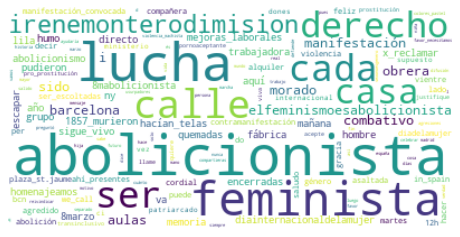

0.6392900943756104


In [94]:
start = time.time()

plot_world_cloud(com_9_phrases)    
    
end = time.time()
print(end - start)

**Detecció temàtiques amb LDA**

In [139]:
start = time.time()

com_9_modelsLDA, com_9_coherences = get_modelsLDA_and_coherences(com_9_phrases, 10, 10)

end = time.time()
print(end - start)

168.95016813278198


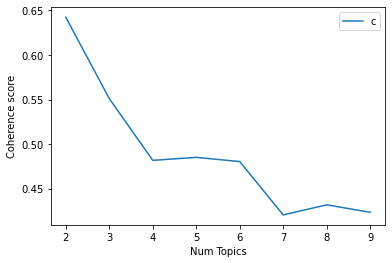

In [140]:
plot_coherences(com_9_coherences, 10)

In [208]:
plot_pyLDAvis(com_9_phrases, com_9_modelsLDA[0])

PreparedData(topic_coordinates=              x    y  topics  cluster      Freq
topic                                          
1      0.199937  0.0       1        1  58.28018
0     -0.199937  0.0       2        1  41.71982, topic_info=                     Term        Freq       Total Category  logprob  loglift
491  irenemonterodimision  360.000000  360.000000  Default  30.0000  30.0000
445                morado  289.000000  289.000000  Default  29.0000  29.0000
447               obreras  278.000000  278.000000  Default  28.0000  28.0000
434         abolicionismo  277.000000  277.000000  Default  27.0000  27.0000
444               memoria  264.000000  264.000000  Default  26.0000  26.0000
..                    ...         ...         ...      ...      ...      ...
468              in_spain  226.097797  226.568348   Topic2  -5.1838   0.8721
491  irenemonterodimision  356.128624  360.041049   Topic2  -4.7295   0.8633
64                   aquí  231.081612  232.166114   Topic2  -5.1620   0.8695
442                 lucha  606.006996  873.348020   Topic2  -4.1979   0.5088
15                   sido  271.230070  374.691405   Topic2  -5.0018   0.5511

[115 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
3         2  0.996226            12h
433       2  0.998732  1857_murieron
434       2  0.998953  abolicionismo
112       1  0.789638  abolicionista
112       2  0.209620  abolicionista
...     ...       ...            ...
294       1  0.655838             va
294       2  0.343211             va
667       1  0.004075       vientres
667       2  0.998366       vientres
451       2  0.997027     x_reclamar

[110 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [209]:
plot_pyLDAvis(com_9_phrases, com_9_modelsLDA[1])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.091532  0.205492       1        1  39.706536
0     -0.178593 -0.165622       2        1  33.267844
2      0.270125 -0.039870       3        1  27.025620, topic_info=               Term        Freq       Total Category  logprob  loglift
15             sido  373.000000  373.000000  Default  30.0000  30.0000
445          morado  294.000000  294.000000  Default  29.0000  29.0000
114            cada  405.000000  405.000000  Default  28.0000  28.0000
447         obreras  284.000000  284.000000  Default  27.0000  27.0000
434   abolicionismo  282.000000  282.000000  Default  26.0000  26.0000
..              ...         ...         ...      ...      ...      ...
3               12h  226.711784  227.305155   Topic3  -4.7469   1.3058
5     ahí_presentes  226.711784  227.305155   Topic3  -4.7469   1.3058
6          asaltada  226.711784  227.305155   Topic3  -4.7469   1.3058
13   plaza_st.jaume  226.711784  227.305155   Topic3  -4.7469   1.3058
442           lucha  368.677618  888.368228   Topic3  -4.2606   0.4289

[164 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
3         3  0.998658              12h
433       3  0.998234    1857_murieron
405       1  0.533834                8
405       2  0.462656                8
109       1  0.004817  8mabolicionista
...     ...       ...              ...
871       3  0.061025             vida
667       2  0.996183         vientres
418       1  0.997803      visibilizar
474       2  0.999459          we_call
451       3  0.996604       x_reclamar

[177 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

In [210]:
pprint(com_9_modelsLDA[0].print_topics()) 

[(0,
  '0.015*"lucha" + 0.009*"irenemonterodimision" + 0.007*"morado" + '
  '0.007*"obreras" + 0.007*"abolicionismo" + 0.007*"sido" + 0.007*"memoria" + '
  '0.006*"fábrica" + 0.006*"pudieron" + 0.006*"homenajeamos"'),
 (1,
  '0.014*"abolicionista" + 0.007*"cada" + 0.007*"calles" + 0.007*"ser" + '
  '0.006*"combativo" + 0.005*"i" + 0.005*"casas" + 0.005*"aulas" + '
  '0.005*"manifestación" + 0.005*"lucha"')]


In [211]:
pprint(com_9_modelsLDA[1].print_topics()) 

[(0,
  '0.010*"irenemonterodimision" + 0.009*"abolicionista" + 0.008*"lucha" + '
  '0.008*"alquiler" + 0.008*"vientres" + 0.007*"aquí" + 0.007*"in_spain" + '
  '0.007*"we_call" + 0.007*"barcelona" + 0.007*"feministas"'),
 (1,
  '0.013*"abolicionista" + 0.011*"cada" + 0.010*"calles" + 0.009*"ser" + '
  '0.008*"combativo" + 0.008*"casas" + 0.008*"aulas" + 0.007*"lucha" + '
  '0.005*"elfeminismoesabolicionista" + 0.004*"va"'),
 (2,
  '0.014*"sido" + 0.014*"lucha" + 0.011*"morado" + 0.011*"obreras" + '
  '0.011*"abolicionismo" + 0.010*"memoria" + 0.010*"fábrica" + '
  '0.010*"pudieron" + 0.010*"homenajeamos" + 0.010*"escapar"')]


Tenint en compte la coherència obtinguda, els gràfics i els termes de cada temàtica elegim k=3.

### Comunitat 10

**Obtenció dels missatges**

In [46]:
nodes_com_10 = get_nicknames(G, 10)
len(nodes_com_10)

3197

In [47]:
start = time.time()
tweets_com_10 = get_tweets(nodes_com_10, db)

end = time.time()
print(end - start)

5637.113330841064


In [48]:
len(tweets_com_10)

9014

In [49]:
f = open('tweets/tweets_comunitats/com_10_tweets.txt', 'w', encoding='utf-8')

for tweet in tweets_com_10:
    f.write(tweet.replace('\n', ' ')+'\n')
        
f.close()

In [77]:
with open('tweets/tweets_comunitats/com_10_tweets.txt', 'r', encoding='utf-8') as f:
    com_10_tweets = f.readlines()
    print(com_10_tweets[0:5])

['Hoy que todas las grandes empresas hablan del #8M, dos datos a tener en cuenta:  1. Las mujeres solo suponen el 26,1% de los consejos de administración de las empresas españolas cotizadas. 2. Solo 4 mujeres lideran una empresa del IBEX 35 (2 de ellas -Ortega y Botín-, herederas)\n', '«Somos as netas das #meigas que non puidestes queimar».   Feliz #8M , seguimos 🌚   #igualdad https://t.co/jQMtSEJHf6\n', '#Feministas #Feminismo #8Marzo2022 #Ecofeministas #Ecofeminismo https://t.co/KqXAcjNS4o\n', '#8M2022  Feliz día de las hembras!!! A todas las lobas que luchan cada día con garras y dientes. https://t.co/GMsSPKwoFS\n', 'Desde este diálogo mente-cuerpo me empeño en crear narrativa #ecológica y #feminista para imaginar #otro mundo posible. Feliz día #8M2022 para todas.#Diadelamujer2022 https://t.co/wl9csIbPfU\n']


Comprovem.

In [78]:
len(com_10_tweets)

9014

**Preparació del text**

In [79]:
start = time.time()

com_10_clean_tweets = clean_tweets(com_10_tweets)

end = time.time()
print(end - start)

0.1752769947052002


Comprovem.

In [80]:
com_10_clean_tweets[0:3]

['Hoy que todas las grandes empresas hablan del  8M  dos datos a tener en cuenta   1. Las mujeres solo suponen el 26 1  de los consejos de administración de las empresas españolas cotizadas. 2. Solo 4 mujeres lideran una empresa del IBEX 35  2 de ellas  Ortega y Botín   herederas  ',
 ' Somos as netas das  meigas que non puidestes queimar .   Feliz itemDeleted   seguimos itemDeleted     igualdad itemDeleted  ',
 ' Feministas  Feminismo itemdeleted   Ecofeministas  Ecofeminismo itemDeleted  ']

In [81]:
start = time.time()

com_10_model_phrases = create_phrases_model(com_10_clean_tweets)

end = time.time()
print(end - start)

2.0988950729370117


Comprovem.

In [82]:
com_10_model_phrases

In [83]:
start = time.time()

com_10_phrases = [get_phrases_filtered_lemmatized(s, com_10_model_phrases, stopwords) for s in com_10_clean_tweets]

end = time.time()
print(end - start)

4.284869909286499


Comprovem.

In [84]:
com_10_phrases[0:3]

[['grandes',
  'empresas',
  'hablan',
  'do',
  'datos',
  'tener',
  'cuenta',
  '1.',
  'solo',
  'suponen',
  '26',
  '1',
  'consejos',
  'administración',
  'empresas',
  'españolas',
  'cotizadas',
  '2.',
  'solo',
  '4',
  'lideran',
  'empresa',
  'ibex',
  '35',
  '2',
  'ortega',
  'botín',
  'herederas'],
 ['a',
  'netas',
  'da',
  'meigas',
  'non',
  'puidestes',
  'queimar',
  'feliz',
  'seguimos'],
 ['feministas', 'ecofeministas', 'ecofeminismo']]

**Creació del núvol de paraules**

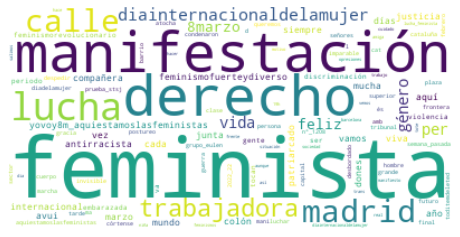

0.5754899978637695


In [142]:
start = time.time()

plot_world_cloud(com_10_phrases, exceptionWords=['i'])    
    
end = time.time()
print(end - start)

**Detecció temàtiques amb LDA**

In [141]:
start = time.time()

com_10_modelsLDA, com_10_coherences = get_modelsLDA_and_coherences(com_10_phrases, 10, 10)

end = time.time()
print(end - start)

155.24182772636414


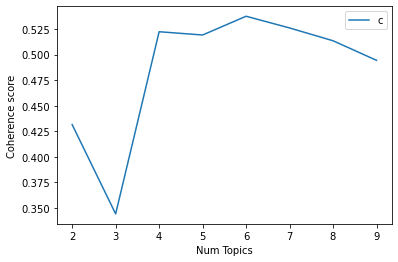

In [142]:
plot_coherences(com_10_coherences, 10)

In [212]:
plot_pyLDAvis(com_10_phrases, com_10_modelsLDA[2])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.126968  0.217688       1        1  27.378787
0      0.290466  0.028625       2        1  27.227150
3     -0.086947 -0.045138       3        1  23.544670
2     -0.076551 -0.201175       4        1  21.849393, topic_info=                                 Term        Freq       Total Category  \
243                                 i  679.000000  679.000000  Default   
712                            madrid  674.000000  674.000000  Default   
713  yovoy8m_aquiestamoslasfeministas  346.000000  346.000000  Default   
295                               per  364.000000  364.000000  Default   
716                             final  256.000000  256.000000  Default   
..                                ...         ...         ...      ...   
65                             género   84.447018  338.472943   Topic4   
608                            luchan   55.108281   76.669162   Topic4   
882                          sociedad   57.278389   96.910038   Topic4   
110                      diadelamujer   60.338608  139.871390   Topic4   
399                           gracias   61.361804  164.742472   Topic4   

     logprob  loglift  
243  30.0000  30.0000  
712  29.0000  29.0000  
713  28.0000  28.0000  
295  27.0000  27.0000  
716  26.0000  26.0000  
..       ...      ...  
65   -5.5315   0.1327  
608  -5.9583   1.1908  
882  -5.9197   0.9951  
110  -5.8677   0.6802  
399  -5.8508   0.5334  

[223 rows x 6 columns], token_table=      Topic      Freq                              Term
term                                                   
720       4  0.981503                  100.000_personas
787       1  0.998515                           2022_22
165       1  0.232982                                 8
165       2  0.548479                                 8
165       3  0.218421                                 8
...     ...       ...                               ...
547       3  0.987351                            vuelve
713       3  0.999118  yovoy8m_aquiestamoslasfeministas
263       2  0.993896                                és
733       1  0.077351                             éxito
733       4  0.912747                             éxito

[279 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 3])

In [213]:
plot_pyLDAvis(com_10_phrases, com_10_modelsLDA[4])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.341061  0.014127       1        1  20.689670
5      0.091224 -0.014138       2        1  19.231160
1      0.090945 -0.016848       3        1  17.001796
4      0.077372  0.243906       4        1  15.704471
2      0.049024 -0.233118       5        1  14.490266
3      0.032496  0.006070       6        1  12.882638, topic_info=                                 Term        Freq       Total Category  \
243                                 i  663.000000  663.000000  Default   
712                            madrid  676.000000  676.000000  Default   
295                               per  356.000000  356.000000  Default   
716                             final  248.000000  248.000000  Default   
713  yovoy8m_aquiestamoslasfeministas  353.000000  353.000000  Default   
..                                ...         ...         ...      ...   
308                          queremos   45.018843  131.381979   Topic6   
368                              aquí   46.820587  215.739368   Topic6   
508                            futuro   43.778807  116.990849   Topic6   
178                              vida   41.949640  230.877978   Topic6   
61          diainternacionaldelamujer   42.072527  423.567424   Topic6   

     logprob  loglift  
243  30.0000  30.0000  
712  29.0000  29.0000  
295  28.0000  28.0000  
716  27.0000  27.0000  
713  26.0000  26.0000  
..       ...      ...  
308  -5.6323   0.9783  
368  -5.5930   0.5215  
508  -5.6602   1.0663  
178  -5.7029   0.3439  
61   -5.6999  -0.2600  

[328 rows x 6 columns], token_table=      Topic      Freq                              Term
term                                                   
720       5  0.974843                  100.000_personas
787       4  0.997843                           2022_22
3313      6  0.980909                                22
165       1  0.494670                                 8
165       2  0.264477                                 8
...     ...       ...                               ...
713       5  0.042406  yovoy8m_aquiestamoslasfeministas
713       6  0.163969  yovoy8m_aquiestamoslasfeministas
263       1  0.993418                                és
733       3  0.079884                             éxito
733       5  0.910682                             éxito

[476 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 2, 5, 3, 4])

In [214]:
plot_pyLDAvis(com_10_phrases, com_10_modelsLDA[5])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.350846 -0.018118       1        1  18.651360
5      0.103303 -0.061866       2        1  16.885029
4      0.054909  0.301263       3        1  14.274369
6      0.090455 -0.050438       4        1  13.186517
1      0.005220  0.022205       5        1  12.803007
2      0.069303 -0.161416       6        1  12.567217
3      0.027656 -0.031630       7        1  11.632500, topic_info=                                 Term        Freq       Total Category  \
243                                 i  669.000000  669.000000  Default   
712                            madrid  663.000000  663.000000  Default   
295                               per  359.000000  359.000000  Default   
716                             final  245.000000  245.000000  Default   
65                             género  336.000000  336.000000  Default   
..                                ...         ...         ...      ...   
713  yovoy8m_aquiestamoslasfeministas   66.833167  348.972193   Topic7   
107                             lucha   73.210308  507.725150   Topic7   
73                              vamos   48.850872  191.634236   Topic7   
178                              vida   49.397364  231.664678   Topic7   
383         díainternacionaldelamujer   39.891898  114.126144   Topic7   

     logprob  loglift  
243  30.0000  30.0000  
712  29.0000  29.0000  
295  28.0000  28.0000  
716  27.0000  27.0000  
65   26.0000  26.0000  
..       ...      ...  
713  -5.1351   0.4986  
107  -5.0439   0.2148  
73   -5.4485   0.7846  
178  -5.4374   0.6060  
383  -5.6511   1.1002  

[380 rows x 6 columns], token_table=      Topic      Freq                              Term
term                                                   
1206      5  0.960272                                00
720       6  0.987114                  100.000_personas
3634      4  0.983054                                19
1794      4  0.985123                            19_00h
94        1  0.979513                              2022
...     ...       ...                               ...
713       6  0.040118  yovoy8m_aquiestamoslasfeministas
713       7  0.191992  yovoy8m_aquiestamoslasfeministas
263       1  0.996192                                és
733       5  0.080946                             éxito
733       6  0.906590                             éxito

[572 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 5, 7, 2, 3, 4])

In [215]:
pprint(com_10_modelsLDA[2].print_topics()) 

[(0,
  '0.026*"i" + 0.014*"per" + 0.008*"dones" + 0.007*"avui" + 0.007*"feminista" '
  '+ 0.006*"és" + 0.006*"d" + 0.006*"amb" + 0.006*"l" + 0.004*"manifestació"'),
 (1,
  '0.013*"derechos" + 0.011*"lucha" + 0.009*"género" + 0.009*"trabajadora" + '
  '0.009*"justicia" + 0.007*"periodo" + 0.007*"discriminación" + '
  '0.007*"embarazada" + 0.007*"señores" + 0.007*"febrero"'),
 (2,
  '0.012*"final" + 0.011*"diainternacionaldelamujer" + 0.009*"madrid" + '
  '0.009*"manifestación" + 0.009*"8marzo" + 0.008*"marcha" + 0.006*"feliz" + '
  '0.006*"colón" + 0.006*"ve" + 0.006*"feminista"'),
 (3,
  '0.021*"madrid" + 0.015*"yovoy8m_aquiestamoslasfeministas" + '
  '0.014*"manifestación" + 0.010*"vez" + 0.009*"feministas" + 0.009*"calles" + '
  '0.009*"desbordado" + 0.009*"ma" + 0.008*"junta" + 0.008*"imparable"')]


In [216]:
pprint(com_10_modelsLDA[4].print_topics()) 

[(0,
  '0.033*"i" + 0.018*"per" + 0.011*"dones" + 0.009*"avui" + 0.008*"és" + '
  '0.008*"d" + 0.008*"amb" + 0.008*"l" + 0.007*"feminista" + '
  '0.006*"manifestació"'),
 (1,
  '0.016*"lucha" + 0.010*"mundo" + 0.009*"tocan" + 0.009*"derechos" + '
  '0.009*"gente" + 0.007*"compañeras" + 0.006*"gracias" + 0.006*"clase" + '
  '0.006*"vida" + 0.006*"cada"'),
 (2,
  '0.017*"final" + 0.014*"madrid" + 0.013*"manifestación" + 0.011*"marcha" + '
  '0.008*"colón" + 0.008*"ve" + 0.008*"escenario" + 0.008*"marcha8m" + '
  '0.008*"impresionante_imagen" + 0.007*"papeles"'),
 (3,
  '0.011*"feministas" + 0.011*"manifestación" + 0.008*"junta" + 0.007*"atocha" '
  '+ 0.006*"feliz" + 0.006*"feminista" + 0.006*"opresiones" + 0.006*"vamos" + '
  '0.006*"aquiestamoslasfeministas" + 0.006*"mani"'),
 (4,
  '0.015*"género" + 0.014*"justicia" + 0.013*"trabajadora" + 0.012*"periodo" + '
  '0.012*"discriminación" + 0.012*"embarazada" + 0.012*"señores" + '
  '0.012*"febrero" + 0.012*"postureo" + 0.012*"superior"')

In [217]:
pprint(com_10_modelsLDA[5].print_topics()) 

[(0,
  '0.037*"i" + 0.020*"per" + 0.012*"dones" + 0.010*"avui" + 0.009*"és" + '
  '0.009*"d" + 0.009*"amb" + 0.009*"l" + 0.007*"8" + 0.006*"feminista"'),
 (1,
  '0.022*"lucha" + 0.014*"derechos" + 0.008*"compañeras" + '
  '0.007*"diainternacionaldelamujer" + 0.007*"siempre" + 0.006*"junta" + '
  '0.006*"persona" + 0.006*"mañana" + 0.005*"marzo" + 0.005*"gracias"'),
 (2,
  '0.020*"final" + 0.017*"madrid" + 0.017*"manifestación" + 0.013*"marcha" + '
  '0.009*"ve" + 0.009*"colón" + 0.009*"escenario" + 0.009*"8marzo" + '
  '0.009*"impresionante_imagen" + 0.009*"marcha8m"'),
 (3,
  '0.012*"junta" + 0.009*"feministas" + 0.009*"manifestación" + '
  '0.008*"feminista" + 0.007*"feliz" + 0.006*"lucha" + 0.006*"cada" + '
  '0.006*"yovoy8m_aquiestamoslasfeministas" + 0.005*"aquiestamoslasfeministas" '
  '+ 0.005*"cuidados"'),
 (4,
  '0.020*"género" + 0.015*"justicia" + 0.014*"trabajadora" + 0.013*"periodo" + '
  '0.013*"discriminación" + 0.013*"embarazada" + 0.013*"señores" + '
  '0.013*"febrero" 

Tenint en compte la coherència obtinguda, els gràfics i els termes de cada temàtica elegim k=4.

### Comunitat 11

**Obtenció dels missatges**

In [42]:
nodes_com_11 = get_nicknames(G, 11)
len(nodes_com_11)

2924

In [43]:
start = time.time()
tweets_com_11 = get_tweets(nodes_com_11, db)

end = time.time()
print(end - start)

5428.5939927101135


In [44]:
len(tweets_com_11)

7074

In [45]:
f = open('tweets/tweets_comunitats/com_11_tweets.txt', 'w', encoding='utf-8')

for tweet in tweets_com_11:
    f.write(tweet.replace('\n', ' ')+'\n')
        
f.close()

In [254]:
with open('tweets/tweets_comunitats/com_11_tweets.txt', 'r', encoding='utf-8') as f:
    com_11_tweets = f.readlines()
    print(com_11_tweets[0:5])

['El feminismo de hoy es una doctrina ideológica que pretende colectivizar a las mujeres. ¡No hables en mi nombre! #8M #NoEnMiNombre https://t.co/tPEZwQY2bL vía @Registrador_es\n', 'VÍDEO @EspejoPublico | Las declaraciones de una maestra rusa, sobre el #8M en pleno conflicto con Ucrania: "Rusia no es un país machista, aquí trabajamos y somos amas de casa" https://t.co/jXu5st1qTU\n', '@A3Noticias @EspejoPublico Putin es dictador\n', '@lauragarciagon @violetamolina @anaisbernal @RequenaAguilar @maria_zuil @FatymaCaballero @nu_alabao ¡cuánto aprendo contigo, compañera! 🥰 por más periodismo feminista juntas\n', '♀️  Apenas un 15% de las vías públicas de las 69 ciudades españolas analizadas tienen nombre de mujer.   Te lo contamos en este especial de @Newtral  👉 https://t.co/gVR3SqOAe0   #LasCallesdeEllas #8M2022 #DíaInternacionaldelaMujer https://t.co/ZOnNJZRFTY\n']


Comprovem.

In [88]:
len(com_11_tweets)

7074

**Preparació del text**

In [255]:
start = time.time()

com_11_clean_tweets = clean_tweets(com_11_tweets)

end = time.time()
print(end - start)

0.14261841773986816


Comprovem.

In [90]:
com_11_clean_tweets[0:3]

['El feminismo de hoy es una doctrina ideológica que pretende colectivizar a las mujeres.  No hables en mi nombre  itemDeleted  NoEnMiNombre itemDeleted  vía itemDeleted  ',
 'VÍDEO itemDeleted    Las declaraciones de una maestra rusa  sobre el itemDeleted en pleno conflicto con Ucrania   Rusia no es un país machista  aquí trabajamos y somos amas de casa  itemDeleted  ',
 'itemDeleted  itemDeleted  Putin es dictador ']

In [256]:
start = time.time()

com_11_model_phrases = create_phrases_model(com_11_clean_tweets)

end = time.time()
print(end - start)

1.5059716701507568


Comprovem.

In [92]:
com_11_model_phrases

In [257]:
start = time.time()

com_11_phrases = [get_phrases_filtered_lemmatized(s, com_11_model_phrases, stopwords) for s in com_11_clean_tweets]

end = time.time()
print(end - start)

3.1236705780029297


Comprovem.

In [94]:
com_11_phrases[0:3]

[['doctrina',
  'ideológica',
  'pretende',
  'colectivizar',
  'hables',
  'nombre',
  'noenminombre',
  'vía'],
 ['vídeo',
  'declaraciones',
  'maestra',
  'rusa',
  'pleno',
  'conflicto',
  'ucrania_rusia',
  'país',
  'machista',
  'aquí_trabajamos',
  'amas',
  'casa'],
 ['putin', 'dictador']]

**Creació del núvol de paraules**

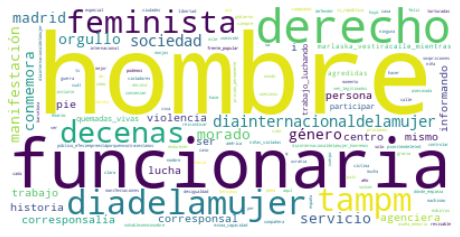

0.6073763370513916


In [144]:
start = time.time()

plot_world_cloud(com_11_phrases)    
    
end = time.time()
print(end - start)

In [161]:
count = 0
for tweet in com_11_tweets:
    if 'funcionaria' in tweet:
        print(tweet)
        count +=1
    if count >= 10:
        break

Hoy los logos del @interiorgob  y @IIPPGob  son morados por el #8M  Pero las funcionarias de #sosprisiones siguen ABANDONADAS ‼️ Siguen siendo INVISIBLES para este ministerio ‼️ Menos morado y más soluciones! Seguimos esperando... #sosprisiones  #tuabandonomepuedematar

#8M  #sosprisiones #tuabandonomepuedematar  Por todas las funcionarias de #sosprisiones INVISIBLES pero imprescindibles @interiorgob  @IIPPGob https://t.co/cMfiso5Mcy

#8M  #sosprisiones #tuabandonomepuedematar  Por todas las funcionarias de #sosprisiones INVISIBLES pero imprescindibles @interiorgob  @IIPPGob https://t.co/cMfiso5Mcy

#8M  #sosprisiones #tuabandonomepuedematar  Por todas las funcionarias de #sosprisiones INVISIBLES pero imprescindibles @interiorgob  @IIPPGob https://t.co/cMfiso5Mcy

#8M  #sosprisiones #tuabandonomepuedematar  Por todas las funcionarias de #sosprisiones INVISIBLES pero imprescindibles @interiorgob  @IIPPGob https://t.co/cMfiso5Mcy

#8M  #sosprisiones #tuabandonomepuedematar  Por todas las

**Detecció temàtiques amb LDA**

In [258]:
start = time.time()

com_11_modelsLDA, com_11_coherences = get_modelsLDA_and_coherences(com_11_phrases, 10, 10)

end = time.time()
print(end - start)

131.84555006027222


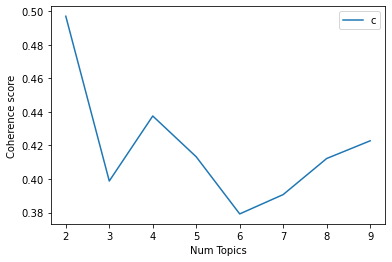

In [259]:
plot_coherences(com_11_coherences, 10)

In [296]:
plot_pyLDAvis(com_11_phrases, com_11_modelsLDA[0])

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.171949  0.0       1        1  50.219135
1     -0.171949  0.0       2        1  49.780865, topic_info=                Term        Freq       Total Category  logprob  loglift
571          decenas  244.000000  244.000000  Default  30.0000  30.0000
151    manifestación  246.000000  246.000000  Default  29.0000  29.0000
104  manifestaciones  231.000000  231.000000  Default  28.0000  28.0000
95      diadelamujer  227.000000  227.000000  Default  27.0000  27.0000
691            tampm  205.000000  205.000000  Default  26.0000  26.0000
..               ...         ...         ...      ...      ...      ...
103           madrid  153.353983  268.709749   Topic2  -5.4481   0.1367
153               va  120.219644  187.203186   Topic2  -5.6916   0.2547
232           hombre  137.573497  477.296063   Topic2  -5.5567  -0.5464
808          trabajo  119.285682  210.702673   Topic2  -5.6994   0.1286
96            género  116.817573  200.643833   Topic2  -5.7203   0.1566

[127 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
681       1  0.994006         146
1795      2  0.999538   agenciera
682       1  0.994006   agredidas
909       1  0.987561         amb
1836      2  0.999395  asesinadas
...     ...       ...         ...
278       1  0.084554   violencia
278       2  0.914242   violencia
594       1  0.995060        viva
53        1  0.009079    víctimas
53        2  0.998656    víctimas

[136 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [297]:
plot_pyLDAvis(com_11_phrases, com_11_modelsLDA[2])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.055416 -0.101543       1        1  29.936692
0     -0.135637  0.221366       2        1  24.144873
1      0.265230  0.045698       3        1  23.658634
3     -0.074176 -0.165521       4        1  22.259801, topic_info=                          Term        Freq       Total Category  logprob  \
571                    decenas  237.000000  237.000000  Default  30.0000   
104            manifestaciones  224.000000  224.000000  Default  29.0000   
95                diadelamujer  236.000000  236.000000  Default  28.0000   
269                  conmemora  187.000000  187.000000  Default  27.0000   
686                     morado  180.000000  180.000000  Default  26.0000   
..                         ...         ...         ...      ...      ...   
527                       vida   64.670641  114.913384   Topic4  -5.5067   
808                    trabajo   65.892954  209.104224   Topic4  -5.4880   
214                    gracias   46.388572   81.768521   Topic4  -5.8390   
46   diainternacionaldelamujer   47.243533  235.219365   Topic4  -5.8207   
691                      tampm   45.882530  213.077334   Topic4  -5.8500   

     loglift  
571  30.0000  
104  29.0000  
95   28.0000  
269  27.0000  
686  26.0000  
..       ...  
527   0.9275  
808   0.3476  
214   0.9355  
46   -0.1028  
691  -0.0332  

[217 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1815      1  0.990285        10
681       2  0.995074       146
2844      3  0.021872         5
2844      4  0.962389         5
812       1  0.118866    8marzo
...     ...       ...       ...
2092      1  0.997966    volver
3240      2  0.976974       voz
611       4  0.972819    vuelto
53        1  0.997356  víctimas
2414      2  0.982073        és

[272 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 4])

In [298]:
pprint(com_11_modelsLDA[0].print_topics()) 

[(0,
  '0.009*"hombre" + 0.007*"manifestación" + 0.006*"diadelamujer" + '
  '0.006*"tampm" + 0.006*"sociedad" + 0.005*"feministas" + 0.005*"conmemora" + '
  '0.005*"morado" + 0.005*"centro" + 0.004*"pie"'),
 (1,
  '0.007*"decenas" + 0.006*"manifestaciones" + 0.006*"derechos" + '
  '0.006*"persona" + 0.005*"país" + 0.005*"historia" + 0.005*"ver" + '
  '0.005*"violencia" + 0.005*"orgullo" + 0.005*"mile"')]


In [299]:
pprint(com_11_modelsLDA[2].print_topics()) 

[(0,
  '0.015*"hombre" + 0.013*"diadelamujer" + 0.011*"manifestación" + '
  '0.011*"conmemora" + 0.010*"morado" + 0.010*"sociedad" + 0.010*"centro" + '
  '0.010*"tampm" + 0.009*"pie" + 0.009*"funcionarias"'),
 (1,
  '0.014*"decenas" + 0.013*"manifestaciones" + 0.012*"madrid" + '
  '0.010*"orgullo" + 0.009*"mile" + 0.009*"persona" + 0.009*"servicio" + '
  '0.009*"agenciera" + 0.009*"corresponsal" + 0.009*"corresponsalías"'),
 (2,
  '0.009*"violencia" + 0.008*"género" + 0.007*"feministas" + 0.006*"historia" '
  '+ 0.006*"trabajo" + 0.005*"víctimas" + 0.005*"diainternacionaldelamujer" + '
  '0.005*"hombre" + 0.005*"especial" + 0.005*"mismo"'),
 (3,
  '0.005*"podemos" + 0.005*"violadores" + 0.004*"asesinos" + 0.004*"8marzo" + '
  '0.004*"trabajo" + 0.004*"penas" + 0.004*"vida" + 0.004*"prisión_permanente" '
  '+ 0.004*"endurecer" + 0.004*"nohablesenminombre8m_irenemonterodimision"')]


Tenint en compte la coherència obtinguda, els gràfics i els termes de cada temàtica elegim k=4.

### Comunitat 16

**Obtenció dels missatges**

In [115]:
nodes_com_16 = get_nicknames(G, 16)
len(nodes_com_16)

1956

In [116]:
start = time.time()
tweets_com_16 = get_tweets(nodes_com_16, db)

end = time.time()
print(end - start)

3533.223426580429


In [117]:
len(tweets_com_16)

7915

In [12]:
f = open('tweets/tweets_comunitats/com_16_tweets.txt', 'w', encoding='utf-8')

for tweet in tweets_com_16:
    f.write(tweet.replace('\n', ' ')+'\n')
        
f.close()

In [260]:
with open('tweets/tweets_comunitats/com_16_tweets.txt', 'r', encoding='utf-8') as f:
    com_16_tweets = f.readlines()
    print(com_16_tweets[0:5])

['🟣 Este 8M adoptamos el lema sufragista de las palabras a los hechos y vamos a pasar a la acción porque para la igualdad #TenemosUnPlan   https://t.co/xeS4L1IQFl  #8M: De las palabras a los hechos\n', '🟣 Este #8M, subrayamos la importancia de los planes y las medidas de igualdad como herramientas para llevar el feminismo a los centros de trabajo  📖 Léelo en Gaceta Sindical  https://t.co/IZZElrhPY9  #TenemosUnPlan https://t.co/9WFlFis8rR\n', '#8M2022 CCOO asume el feminismo y la perspectiva de género en todas sus políticas con hechos “y no solo con palabras” #TenemosUnPlan https://t.co/gQLuHzfR0q https://t.co/UyMHjSEZHC\n', 'PODCAST CONFEDERAL @CCOO 2️⃣4️⃣ #GenteConClase : “#8M2022. Planes de igualdad como herramienta clave para llevar el feminismo a los centros de trabajo” #TenemosUnPlan   https://t.co/61v6pwEGsq https://t.co/iYIAcn0fb1\n', 'Acto conjunto de CCOO y UGT del #8Marzo2022 💜en el día Internacional de la Mujer. Participamos para dejar claro que la juventud #tenemosunplan pa

Comprovem.

In [98]:
len(com_16_tweets)

7915

**Preparació del text**

In [261]:
start = time.time()

com_16_clean_tweets = clean_tweets(com_16_tweets)

end = time.time()
print(end - start)

0.15461349487304688


Comprovem.

In [100]:
com_16_clean_tweets[0:3]

['  Este 8M adoptamos el lema sufragista de las palabras a los hechos y vamos a pasar a la acción porque para la igualdad  TenemosUnPlan   itemDeleted    8M  De las palabras a los hechos ',
 '  Este  8M  subrayamos la importancia de los planes y las medidas de igualdad como herramientas para llevar el feminismo a los centros de trabajo  itemDeleted  Léelo en Gaceta Sindical  itemDeleted    TenemosUnPlan itemDeleted  ',
 'itemDeleted  CCOO asume el feminismo y la perspectiva de género en todas sus políticas con hechos  y no solo con palabras   TenemosUnPlan itemDeleted  itemDeleted  ']

In [262]:
start = time.time()

com_16_model_phrases = create_phrases_model(com_16_clean_tweets)

end = time.time()
print(end - start)

1.627826452255249


Comprovem.

In [102]:
com_16_model_phrases

In [263]:
start = time.time()

com_16_phrases = [get_phrases_filtered_lemmatized(s, com_16_model_phrases, stopwords) for s in com_16_clean_tweets]

end = time.time()
print(end - start)

3.357046604156494


Comprovem.

In [104]:
com_16_phrases[0:3]

[['adoptamos',
  'lema_sufragista',
  'palabras',
  'hechos',
  'vamos',
  'pasar',
  'acción',
  'tenemosunplan',
  'palabras',
  'hechos'],
 ['subrayamos',
  'importancia',
  'plane',
  'medidas',
  'herramientas',
  'llevar',
  'centros',
  'trabajo',
  'léelo',
  'gaceta_sindical',
  'tenemosunplan'],
 ['ccoo',
  'asume',
  'perspectiva',
  'género',
  'políticas',
  'hechos',
  'solo',
  'palabras',
  'tenemosunplan']]

**Creació del núvol de paraules**

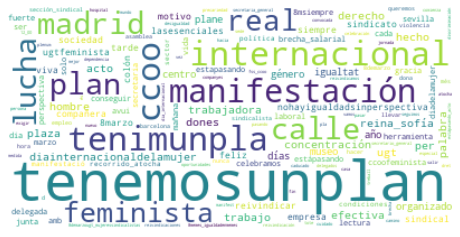

0.6582679748535156


In [145]:
start = time.time()

plot_world_cloud(com_16_phrases, exceptionWords=['i'])    
    
end = time.time()
print(end - start)

In [167]:
count = 0
for tweet in com_16_tweets:
    if 'tenemosunplan' in tweet.lower():
        print(tweet)
        count +=1
    if count >= 10:
        break

🟣 Este 8M adoptamos el lema sufragista de las palabras a los hechos y vamos a pasar a la acción porque para la igualdad #TenemosUnPlan   https://t.co/xeS4L1IQFl  #8M: De las palabras a los hechos

🟣 Este #8M, subrayamos la importancia de los planes y las medidas de igualdad como herramientas para llevar el feminismo a los centros de trabajo  📖 Léelo en Gaceta Sindical  https://t.co/IZZElrhPY9  #TenemosUnPlan https://t.co/9WFlFis8rR

#8M2022 CCOO asume el feminismo y la perspectiva de género en todas sus políticas con hechos “y no solo con palabras” #TenemosUnPlan https://t.co/gQLuHzfR0q https://t.co/UyMHjSEZHC

PODCAST CONFEDERAL @CCOO 2️⃣4️⃣ #GenteConClase : “#8M2022. Planes de igualdad como herramienta clave para llevar el feminismo a los centros de trabajo” #TenemosUnPlan   https://t.co/61v6pwEGsq https://t.co/iYIAcn0fb1

Acto conjunto de CCOO y UGT del #8Marzo2022 💜en el día Internacional de la Mujer. Participamos para dejar claro que la juventud #tenemosunplan para la igualdad. Co

**Detecció temàtiques amb LDA**

In [264]:
start = time.time()

com_16_modelsLDA, com_16_coherences = get_modelsLDA_and_coherences(com_16_phrases, 10, 10)

end = time.time()
print(end - start)

166.23465037345886


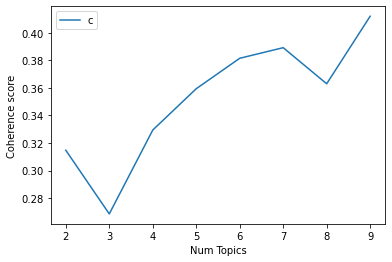

In [265]:
plot_coherences(com_16_coherences, 10)

In [300]:
plot_pyLDAvis(com_16_phrases, com_16_modelsLDA[4])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.030963  0.184767       1        1  26.748828
0     -0.192533  0.118241       2        1  16.927693
2     -0.079387 -0.246027       3        1  16.132885
1      0.098666 -0.048131       4        1  13.918661
3      0.260447  0.041703       5        1  13.181321
5     -0.056231 -0.050552       6        1  13.090612, topic_info=                          Term         Freq        Total Category  logprob  \
113                      lucha   525.000000   525.000000  Default  30.0000   
34               internacional   659.000000   659.000000  Default  29.0000   
57                       plaza   356.000000   356.000000  Default  28.0000   
49                 reina_sofía   301.000000   301.000000  Default  27.0000   
6                tenemosunplan  3081.000000  3081.000000  Default  26.0000   
..                         ...          ...          ...      ...      ...   
158  diainternacionaldelamujer    63.355402   459.828810   Topic6  -5.0712   
75                trabajadoras    54.794623   300.705247   Topic6  -5.2164   
55                      madrid    57.759194   557.618146   Topic6  -5.1637   
34               internacional    53.800743   659.865686   Topic6  -5.2347   
91                      hombre    41.562782   400.049377   Topic6  -5.4928   

     loglift  
113  30.0000  
34   29.0000  
57   28.0000  
49   27.0000  
6    26.0000  
..       ...  
158   0.0512  
75    0.3307  
55   -0.2341  
34   -0.4735  
91   -0.2311  

[374 rows x 6 columns], token_table=      Topic      Freq                  Term
term                                       
1084      2  0.987278                 12_00
202       2  0.964182                   12h
135       6  0.975876  19.00._manifestación
982       5  0.973220              1_bretxa
1640      2  0.153043                     2
...     ...       ...                   ...
139       6  0.981380              volvemos
1548      4  0.981321                   voz
1612      3  0.961382                  área
1011      3  0.978872                    és
1011      4  0.015060                    és

[548 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 3, 2, 4, 6])

In [301]:
plot_pyLDAvis(com_16_phrases, com_16_modelsLDA[5])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.112235 -0.013988       1        1  21.916404
6      0.302531  0.098696       2        1  16.645645
0     -0.072671  0.166664       3        1  15.621553
1     -0.088252 -0.003510       4        1  12.416870
5     -0.100838 -0.065038       5        1  12.210745
2     -0.019798  0.085541       6        1  11.154361
3      0.091262 -0.268365       7        1  10.034421, topic_info=              Term        Freq        Total Category  logprob  loglift
57           plaza  348.000000   348.000000  Default  30.0000  30.0000
154            per  399.000000   399.000000  Default  29.0000  29.0000
34   internacional  653.000000   653.000000  Default  28.0000  28.0000
49     reina_sofía  293.000000   293.000000  Default  27.0000  27.0000
113          lucha  527.000000   527.000000  Default  26.0000  26.0000
..             ...         ...          ...      ...      ...      ...
103           plan   41.242387   567.369938   Topic7  -5.2346  -0.3224
6    tenemosunplan   35.871762  3067.553135   Topic7  -5.3741  -2.1495
39             ugt   26.086162   316.032693   Topic7  -5.6927  -0.1953
194           días   25.660213   225.363212   Topic7  -5.7092   0.1264
79   concentración   25.485059   336.897895   Topic7  -5.7160  -0.2825

[424 rows x 6 columns], token_table=      Topic      Freq                  Term
term                                       
1084      3  0.990552                 12_00
77        3  0.979588              12_horas
202       3  0.987241                   12h
135       5  0.953134  19.00._manifestación
982       7  0.959355              1_bretxa
...     ...       ...                   ...
1548      4  0.961335                   voz
758       6  0.979866                   vía
106       2  0.966102                   web
1612      3  0.955300                  área
1011      2  0.990014                    és

[628 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 7, 1, 2, 6, 3, 4])

In [302]:
plot_pyLDAvis(com_16_phrases, com_16_modelsLDA[7])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.078189  0.058815       1        1  16.981098
7     -0.076141  0.096489       2        1  12.588942
6     -0.127899 -0.211815       3        1  11.863117
8      0.364083 -0.071561       4        1  11.801051
0     -0.030821 -0.163017       5        1  10.025918
5     -0.091895  0.040148       6        1   9.814955
1     -0.006957  0.104810       7        1   9.321846
3      0.051636  0.195857       8        1   9.318093
2     -0.003817 -0.049726       9        1   8.284979, topic_info=              Term         Freq        Total Category  logprob  loglift
34   internacional   647.000000   647.000000  Default  30.0000  30.0000
6    tenemosunplan  3067.000000  3067.000000  Default  29.0000  29.0000
154            per   397.000000   397.000000  Default  28.0000  28.0000
113          lucha   523.000000   523.000000  Default  27.0000  27.0000
147          dones   332.000000   332.000000  Default  26.0000  26.0000
..             ...          ...          ...      ...      ...      ...
118        siempre    31.475287   166.067714   Topic9  -5.3133   0.8275
372       igualtat    32.748145   275.357376   Topic9  -5.2737   0.3615
370      companyes    27.451427    71.233022   Topic9  -5.4501   1.5372
86          calles    28.765941   326.366324   Topic9  -5.4033   0.0619
211    estapasando    26.755456   134.263569   Topic9  -5.4758   0.8777

[539 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1836      1  0.954572     ..._queda
2391      9  0.979638  .itemdeleted
1084      2  0.085884         12_00
1084      3  0.912517         12_00
77        5  0.980213      12_horas
...     ...       ...           ...
758       1  0.096333           vía
758       9  0.886264           vía
275       2  0.985496      víctimas
1612      6  0.987116          área
1011      4  0.986764            és

[863 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 8, 7, 9, 1, 6, 2, 4, 3])

In [303]:
pprint(com_16_modelsLDA[4].print_topics()) 

[(0,
  '0.061*"tenemosunplan" + 0.032*"internacional" + 0.029*"madrid" + '
  '0.026*"plaza" + 0.023*"reina_sofía" + 0.020*"acto" + 0.020*"concentración" '
  '+ 0.019*"museo" + 0.017*"organizado" + 0.014*"palabras"'),
 (1,
  '0.022*"tenemosunplan" + 0.014*"calles" + 0.008*"feliz" + 0.007*"ccoo" + '
  '0.007*"feministas" + 0.007*"nuevo" + 0.007*"diainternacionaldelamujer" + '
  '0.006*"manifestación" + 0.006*"hombre" + 0.006*"compañeras"'),
 (2,
  '0.028*"tenemosunplan" + 0.026*"manifestación" + 0.019*"per" + 0.019*"dones" '
  '+ 0.014*"tenimunpla" + 0.013*"internacional" + 0.013*"colón" + 0.012*"avui" '
  '+ 0.010*"igualtat" + 0.009*"feminista"'),
 (3,
  '0.016*"diainternacionaldelamujer" + 0.012*"ugtfeminista" + 0.010*"real" + '
  '0.009*"sociedad" + 0.008*"compañeras" + 0.007*"año" + 0.006*"salimos" + '
  '0.006*"tenimunpla" + 0.006*"bien" + 0.005*"reivindicar"'),
 (4,
  '0.062*"tenemosunplan" + 0.025*"lucha" + 0.018*"real" + 0.015*"trabajo" + '
  '0.014*"ccoo" + 0.013*"hombre" + 0.01

In [304]:
pprint(com_16_modelsLDA[5].print_topics()) 

[(0,
  '0.083*"tenemosunplan" + 0.032*"madrid" + 0.031*"internacional" + '
  '0.027*"plaza" + 0.024*"reina_sofía" + 0.021*"concentración" + 0.020*"museo" '
  '+ 0.019*"acto" + 0.018*"organizado" + 0.017*"plan"'),
 (1,
  '0.027*"tenemosunplan" + 0.015*"calles" + 0.011*"ccoo" + '
  '0.009*"manifestación" + 0.008*"queremos" + 0.008*"feministas" + '
  '0.007*"feliz" + 0.007*"nuevo" + 0.006*"ugt" + 0.006*"8m2022"'),
 (2,
  '0.026*"ccoo" + 0.023*"tenemosunplan" + 0.017*"manifestación" + '
  '0.013*"celebramos" + 0.011*"ser" + 0.011*"internacional" + 0.008*"empresas" '
  '+ 0.008*"derechos" + 0.008*"ugt" + 0.007*"tenimunpla"'),
 (3,
  '0.021*"diainternacionaldelamujer" + 0.015*"ugtfeminista" + 0.008*"real" + '
  '0.007*"compañeras" + 0.007*"igualtat" + 0.006*"bien" + 0.006*"año" + '
  '0.006*"tenimunpla" + 0.005*"plan" + 0.005*"cienxcieniguales"'),
 (4,
  '0.058*"tenemosunplan" + 0.028*"lucha" + 0.023*"real" + 0.017*"trabajo" + '
  '0.012*"plan" + 0.012*"género" + 0.011*"centros" + 0.011*"efe

In [305]:
pprint(com_16_modelsLDA[7].print_topics()) 

[(0,
  '0.056*"tenemosunplan" + 0.023*"concentración" + 0.019*"plan" + '
  '0.016*"tenimunpla" + 0.014*"palabras" + 0.013*"trabajadoras" + '
  '0.013*"hechos" + 0.013*"plaza" + 0.011*"internacional" + '
  '0.011*"reina_sofía"'),
 (1,
  '0.032*"tenemosunplan" + 0.027*"calles" + 0.014*"ccoo" + 0.012*"hombre" + '
  '0.009*"ugt" + 0.009*"8msiempre" + 0.008*"nuevo" + 0.008*"8m2022" + '
  '0.007*"manifestación" + 0.007*"empleo"'),
 (2,
  '0.026*"tenemosunplan" + 0.016*"celebramos" + 0.014*"manifestación" + '
  '0.013*"ser" + 0.012*"empresas" + 0.012*"ccoo" + 0.009*"tenimunpla" + '
  '0.008*"delegadas" + 0.008*"plan" + 0.008*"trabajadoras"'),
 (3,
  '0.015*"diainternacionaldelamujer" + 0.015*"ugtfeminista" + 0.014*"real" + '
  '0.013*"año" + 0.012*"sociedad" + 0.010*"derechos" + 0.008*"salimos" + '
  '0.008*"compañeras" + 0.007*"bien" + 0.006*"reivindicar"'),
 (4,
  '0.064*"tenemosunplan" + 0.032*"lucha" + 0.019*"ccoo" + 0.019*"real" + '
  '0.019*"plan" + 0.014*"trabajo" + 0.012*"8" + 0.011*"

Tenint en compte la coherència obtinguda, els gràfics i els termes de cada temàtica elegim k=6.

### Comunitat 18

**Obtenció dels missatges**

In [23]:
nodes_com_18 = get_nicknames(G, 18)
len(nodes_com_18)

1805

In [264]:
start = time.time()
tweets_com_18 = get_tweets(nodes_com_18, db)

end = time.time()
print(end - start)

3515.778925180435


In [265]:
len(tweets_com_18)

4043

In [266]:
f = open('tweets/tweets_comunitats/com_18_tweets.txt', 'w', encoding='utf-8')

for tweet in tweets_com_18:
    f.write(tweet.replace('\n', ' ')+'\n')
        
f.close()

In [25]:
with open('tweets/tweets_comunitats/com_18_tweets.txt', 'r', encoding='utf-8') as f:
    com_18_tweets = f.readlines()
    print(com_18_tweets[0:5])

['Hoy, #8M, es el día de todas las mujeres, sin exclusiones, porque la lucha por la igualdad solo es posible desde la unidad.   Seguimos trabajando para conseguir la igualdad real, sin enfrentamientos ni politizaciones, sin renunciar a las ideas propias, a ser #MujeresLibres. https://t.co/X7si2Fvntq\n', '👉🏼 Hoy, #8M, es el día de todas las mujeres, sin exclusiones, porque la lucha por la igualdad solo es posible desde la unidad.   Seguimos trabajando para conseguir la igualdad real, sin enfrentamientos ni politizaciones, sin renunciar a las ideas propias, a ser #MujeresLibres. https://t.co/cWNtokq6Yo\n', 'Hoy #8M día de todas la #Mujeres, mi apoyo y recuerdo especial a esas mujeres y niñas de #Ucrania cuyos Derechos Humanos están siendo violados por la guerra inhumana de #Putin . Mujeres aterradas, asesinadas y violadas por #Rusia. El color morado deja paso hoy al azul y amarillo. https://t.co/ixWcLi9tNs\n', '🔵Hoy, #8M, es el día de todas las mujeres, sin exclusiones, porque la lucha p

Comprovem.

In [26]:
len(com_18_tweets)

4043

**Preparació del text**

In [27]:
start = time.time()

com_18_clean_tweets = clean_tweets(com_18_tweets)

end = time.time()
print(end - start)

0.08379960060119629


Comprovem.

In [28]:
com_18_clean_tweets[0:3]

['Hoy   8M  es el día de todas las mujeres  sin exclusiones  porque la lucha por la igualdad solo es posible desde la unidad.   Seguimos trabajando para conseguir la igualdad real  sin enfrentamientos ni politizaciones  sin renunciar a las ideas propias  a ser  MujeresLibres. itemDeleted  ',
 'itemDeleted  Hoy   8M  es el día de todas las mujeres  sin exclusiones  porque la lucha por la igualdad solo es posible desde la unidad.   Seguimos trabajando para conseguir la igualdad real  sin enfrentamientos ni politizaciones  sin renunciar a las ideas propias  a ser  MujeresLibres. itemDeleted  ',
 'Hoy itemDeleted día de todas la  Mujeres  mi apoyo y recuerdo especial a esas mujeres y niñas de  Ucrania cuyos Derechos Humanos están siendo violados por la guerra inhumana de  Putin . Mujeres aterradas  asesinadas y violadas por  Rusia. El color morado deja paso hoy al azul y amarillo. itemDeleted  ']

In [329]:
start = time.time()

com_18_model_phrases = create_phrases_model(com_18_clean_tweets)

end = time.time()
print(end - start)

0.9923655986785889


Comprovem.

In [112]:
com_18_model_phrases

In [330]:
start = time.time()

com_18_phrases = [get_phrases_filtered_lemmatized(s, com_18_model_phrases, stopwords) for s in com_18_clean_tweets]

end = time.time()
print(end - start)

1.9611713886260986


Comprovem.

In [114]:
com_18_phrases[0:3]

[['exclusiones',
  'lucha',
  'solo',
  'posible',
  'unidad',
  'seguimos_trabajando',
  'conseguir',
  'real',
  'enfrentamientos',
  'politizaciones',
  'renunciar',
  'idea',
  'propias',
  'ser_mujereslibres'],
 ['exclusiones',
  'lucha',
  'solo',
  'posible',
  'unidad',
  'seguimos_trabajando',
  'conseguir',
  'real',
  'enfrentamientos',
  'politizaciones',
  'renunciar',
  'idea',
  'propias',
  'ser_mujereslibres'],
 ['apoyo',
  'recuerdo',
  'especial',
  'niñas',
  'ucrania_cuyos',
  'derechos_humanos',
  'siendo',
  'violados',
  'guerra_inhumana',
  'putin',
  'aterradas',
  'asesinadas',
  'violadas',
  'rusia',
  'color',
  'morado_deja',
  'paso',
  'azul',
  'amarillo']]

**Creació del núvol de paraules**

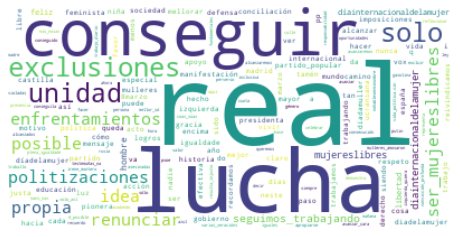

0.6611111164093018


In [139]:
start = time.time()

plot_world_cloud(com_18_phrases)    
    
end = time.time()
print(end - start)

In [172]:
count = 0
for tweet in com_18_tweets:
    if 'mujereslibres' in tweet.lower():
        print(tweet)
        count +=1
    if count >= 50:
        break

Hoy, #8M, es el día de todas las mujeres, sin exclusiones, porque la lucha por la igualdad solo es posible desde la unidad.   Seguimos trabajando para conseguir la igualdad real, sin enfrentamientos ni politizaciones, sin renunciar a las ideas propias, a ser #MujeresLibres. https://t.co/X7si2Fvntq

👉🏼 Hoy, #8M, es el día de todas las mujeres, sin exclusiones, porque la lucha por la igualdad solo es posible desde la unidad.   Seguimos trabajando para conseguir la igualdad real, sin enfrentamientos ni politizaciones, sin renunciar a las ideas propias, a ser #MujeresLibres. https://t.co/cWNtokq6Yo

🔵Hoy, #8M, es el día de todas las mujeres, sin exclusiones, porque la lucha por la igualdad solo es posible desde la unidad.  Seguimos trabajando para conseguir la igualdad real, sin enfrentamientos ni politizaciones, sin renunciar a las ideas propias, a ser #MujeresLibres. https://t.co/w6Ie0nzJrY

💜 Todos los días   #MujeresLibres  #8M #DíaDeLaMujer #DíaDeLaMujerTrabajadora #CentradosEnAragón 

**Detecció temàtiques amb LDA**

In [331]:
start = time.time()

com_18_modelsLDA, com_18_coherences = get_modelsLDA_and_coherences(com_18_phrases, 10, 10)

end = time.time()
print(end - start)

85.11726784706116


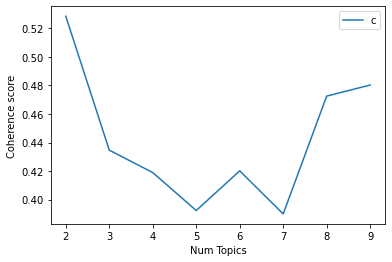

In [332]:
plot_coherences(com_18_coherences, 10)

In [333]:
plot_pyLDAvis(com_18_phrases, com_18_modelsLDA[0])

PreparedData(topic_coordinates=           x    y  topics  cluster       Freq
topic                                        
1      0.207  0.0       1        1  58.171533
0     -0.207  0.0       2        1  41.828467, topic_info=                          Term        Freq       Total Category  logprob  \
8                         real  608.000000  608.000000  Default  30.0000   
0                    conseguir  421.000000  421.000000  Default  29.0000   
2                  exclusiones  401.000000  401.000000  Default  28.0000   
4                        lucha  401.000000  401.000000  Default  27.0000   
13                      unidad  387.000000  387.000000  Default  26.0000   
..                         ...         ...         ...      ...      ...   
233  diainternacionaldelamujer  233.704513  323.171351   Topic2  -4.3447   
159                   sociedad  137.446347  182.423632   Topic2  -4.8755   
36               mujereslibres  150.141797  260.631524   Topic2  -4.7872   
602                          a  165.982268  318.483876   Topic2  -4.6869   
178                      feliz  116.790721  171.635378   Topic2  -5.0383   

     loglift  
8    30.0000  
0    29.0000  
2    28.0000  
4    27.0000  
13   26.0000  
..       ...  
233   0.5475  
159   0.5885  
36    0.3201  
602   0.2199  
178   0.4866  

[106 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
602       1  0.480401             a
602       2  0.521219             a
453       2  0.996438  alcanzaremos
3299      2  0.999357       apuesta
454       2  0.996438   avanzaremos
...     ...       ...           ...
13        1  0.002580        unidad
13        2  0.998393        unidad
57        1  0.991741           ver
977       1  0.998316          viva
7540      1  0.996118          your

[90 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [339]:
plot_pyLDAvis(com_18_phrases, com_18_modelsLDA[1])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.108362  0.227351       1        1  41.598454
0     -0.275728 -0.030275       2        1  32.756047
2      0.167366 -0.197076       3        1  25.645499, topic_info=             Term        Freq       Total Category  logprob  loglift
8            real  655.000000  655.000000  Default  30.0000  30.0000
0       conseguir  454.000000  454.000000  Default  29.0000  29.0000
2     exclusiones  432.000000  432.000000  Default  28.0000  28.0000
4           lucha  432.000000  432.000000  Default  27.0000  27.0000
13         unidad  417.000000  417.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
5002        robba   34.512700   35.121189   Topic3  -5.7682   1.3433
425      homenaje   43.154093   44.280358   Topic3  -5.5447   1.3350
2456            f   36.510058   37.269000   Topic3  -5.7119   1.3402
381           ser   59.068695  134.775966   Topic3  -5.2308   0.5359
1274        puede   37.855942   91.296463   Topic3  -5.6757   0.4805

[146 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
2583      3  0.991019            14
602       3  0.997467             a
540       1  0.998010          acto
453       2  0.995509  alcanzaremos
3916      3  0.987814           amp
...     ...       ...           ...
88        1  0.132447          vida
88        2  0.866923          vida
977       1  0.989210          viva
7540      3  0.992752          your
2553      1  0.982526         único

[137 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

In [334]:
plot_pyLDAvis(com_18_phrases, com_18_modelsLDA[6])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.369972  0.092377       1        1  23.571699
0     -0.015993 -0.129121       2        1  14.102338
1      0.047453 -0.156161       3        1  13.221378
7      0.078702  0.027488       4        1  12.035705
6      0.013657 -0.102362       5        1  10.120146
3      0.043521 -0.094500       6        1   9.954001
2      0.143089  0.254927       7        1   9.259390
5      0.059544  0.107351       8        1   7.735342, topic_info=                Term        Freq       Total Category  logprob  loglift
0          conseguir  501.000000  501.000000  Default  30.0000  30.0000
13            unidad  461.000000  461.000000  Default  29.0000  29.0000
5     politizaciones  458.000000  458.000000  Default  28.0000  28.0000
12              solo  433.000000  433.000000  Default  27.0000  27.0000
1    enfrentamientos  415.000000  415.000000  Default  26.0000  26.0000
..               ...         ...         ...      ...      ...      ...
715            marzo   37.032185   73.924527   Topic8  -4.4992   1.8681
88              vida   36.654661   74.995805   Topic8  -4.5094   1.8435
45            camino   37.430651  111.981025   Topic8  -4.4885   1.4635
51          libertad   34.291293  153.186051   Topic8  -4.5761   1.0626
2        exclusiones   33.469815  460.704785   Topic8  -4.6003  -0.0627

[366 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2583      8  0.980995          14
740       8  0.964648        1910
2527      3  0.972543  5_ejemplos
1205      7  0.979156           8
1108      3  0.099217      8marzo
...     ...       ...         ...
2535      3  0.993942         xxi
7540      8  0.987914        your
5546      7  0.949995      éxitos
2553      3  0.887431       único
2553      4  0.105646       único

[467 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 2, 8, 7, 4, 3, 6])

In [335]:
plot_pyLDAvis(com_18_phrases, com_18_modelsLDA[7])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.390571 -0.035554       1        1  22.255796
0     -0.029083  0.107887       2        1  12.208913
1     -0.085989 -0.134276       3        1  12.097759
7     -0.005329  0.199958       4        1  10.138134
6     -0.024039  0.062483       5        1   9.602391
2     -0.085347  0.106066       6        1   9.594877
8     -0.064583 -0.108961       7        1   8.750450
3     -0.045343  0.002083       8        1   8.005885
5     -0.050857 -0.199685       9        1   7.345793, topic_info=                Term        Freq       Total Category  logprob  loglift
5     politizaciones  476.000000  476.000000  Default  30.0000  30.0000
0          conseguir  514.000000  514.000000  Default  29.0000  29.0000
1    enfrentamientos  431.000000  431.000000  Default  28.0000  28.0000
9          renunciar  429.000000  429.000000  Default  27.0000  27.0000
6            posible  427.000000  427.000000  Default  26.0000  26.0000
..               ...         ...         ...      ...      ...      ...
88              vida   38.308163   71.270247   Topic9  -4.4136   1.9902
715            marzo   38.910905   85.466510   Topic9  -4.3980   1.8242
45            camino   39.342561  102.723759   Topic9  -4.3870   1.6513
51          libertad   34.621533  148.505152   Topic9  -4.5148   1.1549
2        exclusiones   34.979371  477.803151   Topic9  -4.5045  -0.0034

[403 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2583      9  0.971577          14
740       9  0.982654        1910
2527      3  0.984863  5_ejemplos
1205      6  0.338092           8
1205      7  0.659280           8
...     ...       ...         ...
977       7  0.024124        viva
2717      3  0.981320         voy
2535      3  0.984568         xxi
7540      9  0.981583        your
5546      7  0.983267      éxitos

[525 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 2, 8, 7, 3, 9, 4, 6])

In [336]:
pprint(com_18_modelsLDA[0].print_topics()) 

[(0,
  '0.034*"real" + 0.023*"conseguir" + 0.022*"exclusiones" + 0.022*"lucha" + '
  '0.021*"unidad" + 0.021*"politizaciones" + 0.020*"solo" + '
  '0.019*"enfrentamientos" + 0.019*"renunciar" + 0.019*"posible"'),
 (1,
  '0.009*"fuerte" + 0.007*"nunca" + 0.007*"hombre" + 0.006*"a" + 0.006*"ser" + '
  '0.005*"derechos" + 0.005*"país" + 0.004*"it" + 0.004*"the" + '
  '0.004*"mujereslibres"')]


In [340]:
pprint(com_18_modelsLDA[1].print_topics()) 

[(0,
  '0.046*"real" + 0.032*"conseguir" + 0.031*"exclusiones" + 0.031*"lucha" + '
  '0.030*"unidad" + 0.029*"politizaciones" + 0.028*"solo" + '
  '0.027*"enfrentamientos" + 0.026*"renunciar" + 0.026*"posible"'),
 (1,
  '0.013*"fuerte" + 0.010*"nunca" + 0.010*"feliz" + 0.010*"hombre" + '
  '0.008*"diainternacionaldelamujer" + 0.008*"derechos" + '
  '0.007*"mujereslibres" + 0.007*"país" + 0.006*"marzo" + 0.006*"hacer"'),
 (2,
  '0.025*"a" + 0.015*"the" + 0.009*"of" + 0.009*"mayrilvabregithawallé" + '
  '0.009*"it" + 0.006*"co" + 0.006*"eu" + 0.006*"s" + 0.006*"country" + '
  '0.006*"more"')]


In [337]:
pprint(com_18_modelsLDA[6].print_topics()) 

[(0,
  '0.031*"hombre" + 0.015*"celebrado" + 0.015*"s" + 0.014*"real" + '
  '0.014*"cada" + 0.014*"trabajando" + 0.013*"internacional" + '
  '0.013*"mujereslibres" + 0.012*"ser" + 0.011*"sociedad"'),
 (1,
  '0.030*"nunca" + 0.018*"ver" + 0.015*"premio" + 0.014*"viva" + '
  '0.014*"reconoce" + 0.010*"diainternacionaldelamujer" + 0.010*"ser" + '
  '0.010*"madrid" + 0.009*"camino" + 0.009*"puede"'),
 (2,
  '0.030*"a" + 0.030*"the" + 0.019*"país" + 0.018*"of" + 0.017*"it" + '
  '0.013*"hecho" + 0.012*"eu" + 0.012*"másfeminismomejordemocracia" + '
  '0.012*"cobardes" + 0.012*"country"'),
 (3,
  '0.031*"feliz" + 0.027*"conciliación" + 0.024*"corresponsabilidad" + '
  '0.021*"natalidad" + 0.021*"mujeresenigualdad" + 0.021*"apuesta" + '
  '0.014*"gran" + 0.013*"diainternacionaldelamujer" + 0.012*"diadelamujer2022" '
  '+ 0.012*"voy"'),
 (4,
  '0.049*"conseguir" + 0.046*"real" + 0.045*"unidad" + 0.045*"politizaciones" '
  '+ 0.043*"solo" + 0.041*"lucha" + 0.041*"enfrentamientos" + 0.040*"posibl

In [338]:
pprint(com_18_modelsLDA[7].print_topics()) 

[(0,
  '0.041*"fuerte" + 0.023*"hombre" + 0.021*"mayrilvabregithawallé" + 0.016*"a" '
  '+ 0.015*"celebrado" + 0.014*"másfeminismomejordemocracia" + 0.013*"real" + '
  '0.010*"diainternacionaldelamujer" + 0.009*"decir" + 0.009*"internacional"'),
 (1,
  '0.029*"nunca" + 0.018*"ver" + 0.015*"viva" + 0.015*"premio" + 0.014*"pues" '
  '+ 0.014*"cómo" + 0.014*"reconoce" + 0.013*"jodan" + 0.013*"derechitas" + '
  '0.010*"trabajo"'),
 (2,
  '0.042*"a" + 0.038*"the" + 0.023*"of" + 0.016*"eu" + 0.015*"ser" + '
  '0.015*"country" + 0.015*"for" + 0.015*"they" + 0.013*"lost" + '
  '0.011*"place"'),
 (3,
  '0.028*"cobardes" + 0.019*"derechos" + 0.018*"gran" + '
  '0.016*"diadelamujer2022" + 0.016*"general" + 0.015*"alguien" + '
  '0.015*"policías" + 0.014*"rememoramos" + 0.014*"ciudadanía" + '
  '0.007*"madrid"'),
 (4,
  '0.052*"conseguir" + 0.050*"real" + 0.050*"politizaciones" + 0.048*"lucha" + '
  '0.046*"solo" + 0.045*"unidad" + 0.045*"enfrentamientos" + 0.045*"renunciar" '
  '+ 0.045*"posible"

Tenint en compte la coherència obtinguda, els gràfics i els termes de cada temàtica elegim k=9.

Fem algunes comprovacions.

In [29]:
count = 0
for tweet in com_18_tweets:
    if 'country' in tweet.lower():
        print(tweet)
        count +=1
    if count >= 10:
        break

@sanchezcastejon @vonderleyen @NewYorkStateAG @CharlizeAfrica @ashleynicwill @LucyFry @Ashlyn_Harris @Qchasinghorse @GoSydGo @meagantandy @RachieSkarsten @AriMandi @SepidehMoafi @AADaddario ; @sanchezcastejon reliable non-corrupt Energy security co-source as co-distribution country EU!#ARR



In [30]:
count = 0
for tweet in com_18_tweets:
    if 'lost' in tweet.lower():
        print(tweet)
        count +=1
    if count >= 10:
        break

@sanchezcastejon @vonderleyen @NewYorkStateAG @CharlizeAfrica @ashleynicwill @LucyFry @Ashlyn_Harris @Qchasinghorse @GoSydGo @meagantandy @RachieSkarsten @AriMandi @SepidehMoafi @AADaddario : @sanchezcastejon for gas; they ;certain imbeciles of Portugal plated their”Russian roulette” as LOST!#ARR

@sanchezcastejon @vonderleyen @NewYorkStateAG @CharlizeAfrica @ashleynicwill @LucyFry @Ashlyn_Harris @Qchasinghorse @GoSydGo @meagantandy @RachieSkarsten @AriMandi @SepidehMoafi @AADaddario : @sanchezcastejon as it’s place in the market; the Netherlands lost it; PERIOD !#ARR



In [31]:
count = 0
for tweet in com_18_tweets:
    if 'place' in tweet.lower():
        print(tweet)
        count +=1
    if count >= 10:
        break

Carrers i places, plenes de dignitat i feminisme. Moltes veus juntes, diverses i poderoses. Estem i seguirem, als treballs, cases, governs… Som tb les q ja no hi són. Per elles més encara. I les q vindran. Traspassem fronteres i generacions. Mireu-nos: som revolució! #8M #8Març https://t.co/AwJ493Gu4t

@sanchezcastejon @vonderleyen @NewYorkStateAG @CharlizeAfrica @ashleynicwill @LucyFry @Ashlyn_Harris @Qchasinghorse @GoSydGo @meagantandy @RachieSkarsten @AriMandi @SepidehMoafi @AADaddario : @sanchezcastejon mesquinely ; f***** up; Southern EU Countries; 🇪🇸 earned it’s place as an honest!#ARR

@sanchezcastejon @vonderleyen @NewYorkStateAG @CharlizeAfrica @ashleynicwill @LucyFry @Ashlyn_Harris @Qchasinghorse @GoSydGo @meagantandy @RachieSkarsten @AriMandi @SepidehMoafi @AADaddario : @sanchezcastejon as it’s place in the market; the Netherlands lost it; PERIOD !#ARR



In [32]:
count = 0
for tweet in com_18_tweets:
    if 'your' in tweet.lower():
        print(tweet)
        count +=1
    if count >= 10:
        break

@sanchezcastejon @vonderleyen @NewYorkStateAG @CharlizeAfrica @ashleynicwill @LucyFry @Ashlyn_Harris @Qchasinghorse @GoSydGo @meagantandy @RachieSkarsten @AriMandi @SepidehMoafi @AADaddario: Your BOSS/MORE THAN,.: SUPREME III🇺🇸Your SPOUSE/FAM:Cousin/Friend:Fam:BOSS[14] #MAYRILVABREGITHAWALLÉ!#ARR



### Comunitat 24

**Obtenció dels missatges**

In [259]:
nodes_com_24 = get_nicknames(G, 24)
len(nodes_com_24)

1341

In [260]:
start = time.time()
tweets_com_24 = get_tweets(nodes_com_24, db)

end = time.time()
print(end - start)

2634.4268503189087


In [261]:
len(tweets_com_24)

3427

In [262]:
f = open('tweets/tweets_comunitats/com_24_tweets.txt', 'w', encoding='utf-8')

for tweet in tweets_com_24:
    f.write(tweet.replace('\n', ' ')+'\n')
        
f.close()

In [272]:
with open('tweets/tweets_comunitats/com_24_tweets.txt', 'r', encoding='utf-8') as f:
    com_24_tweets = f.readlines()
    print(com_24_tweets[0:5])

['Esta #BitácoraGItana de marzo va acompañada de una #playlist que en esta ocasión lleva por título “Rompiendo el silencio” y recopila temas de Vera Vila, Mercedes Sosa, Lila Downs, La Mona, La Marelu, Mala Rodríguez, Areta Franklin, Ana Tijoux y Beyoncé https://t.co/EI3TU0rzYH\n', 'Este #8m me siento orgullosa de presidir @gitanos_org, una organización que defiende la Igualdad de todas las mujeres. Un momento histórico para seguir trabajando por el avance de las #mujeresGitanas https://t.co/O2NcC6bT3F\n', 'Hace unos minutos, hemos dado lectura en la sede social de @gitanos_org del Comunicado por el Día Internacional de las Mujeres 2022, "Igualdad de género hoy, para un mañana sostenible” #8M #8M2022 #8M2022FSG #8M2022GMG #IGUALDAD REAL YA! https://t.co/OLjueBTXSj https://t.co/7smZuKwWRW\n', '📢 Como cada #8M, la Plataforma del #TercerSector se suma a la conmemoración del #DiaInternacionalDeLaMujer.   🙌 Alcanzar la #igualdad de género, real y efectiva, es fundamental para lograr el desa

Comprovem.

In [118]:
len(com_24_tweets)

3427

**Preparació del text**

In [273]:
start = time.time()

com_24_clean_tweets = clean_tweets(com_24_tweets)

end = time.time()
print(end - start)

0.07579612731933594


Comprovem.

In [120]:
com_24_clean_tweets[0:3]

['Esta  BitácoraGItana de marzo va acompañada de una  playlist que en esta ocasión lleva por título  Rompiendo el silencio  y recopila temas de Vera Vila  Mercedes Sosa  Lila Downs  La Mona  La Marelu  Mala Rodríguez  Areta Franklin  Ana Tijoux y Beyoncé itemDeleted  ',
 'Este  8m me siento orgullosa de presidir itemDeleted   una organización que defiende la Igualdad de todas las mujeres. Un momento histórico para seguir trabajando por el avance de las  mujeresGitanas itemDeleted  ',
 'Hace unos minutos  hemos dado lectura en la sede social de itemDeleted  del Comunicado por el Día Internacional de las Mujeres 2022   Igualdad de género hoy  para un mañana sostenible  itemDeleted itemDeleted  itemDeleted FSG itemDeleted GMG  IGUALDAD REAL YA  itemDeleted  itemDeleted  ']

In [274]:
start = time.time()

com_24_model_phrases = create_phrases_model(com_24_clean_tweets)

end = time.time()
print(end - start)

0.9216387271881104


Comprovem.

In [122]:
com_24_model_phrases

In [275]:
start = time.time()

com_24_phrases = [get_phrases_filtered_lemmatized(s, com_24_model_phrases, stopwords) for s in com_24_clean_tweets]

end = time.time()
print(end - start)

1.8630170822143555


Comprovem.

In [124]:
com_24_phrases[0:3]

[['bitácoragitana',
  'marzo',
  'va',
  'acompañada',
  'playlist',
  'ocasión',
  'lleva',
  'título',
  'rompiendo',
  'silencio',
  'recopila',
  'temas',
  'vera',
  'vila',
  'mercedes',
  'sosa',
  'lila',
  'down',
  'mona',
  'marelu',
  'mala',
  'rodríguez',
  'areta',
  'franklin',
  'ana',
  'tijoux',
  'beyoncé'],
 ['siento',
  'orgullosa',
  'presidir',
  'organización',
  'defiende',
  'momento_histórico',
  'seguir_trabajando',
  'avance',
  'mujeresgitanas'],
 ['hace',
  'minutos',
  'dado',
  'lectura',
  'sede',
  'social',
  'comunicado',
  'internacional',
  '2022',
  'género',
  'mañana_sostenible',
  'fsg',
  'gmg',
  'real']]

**Creació del núvol de paraules**

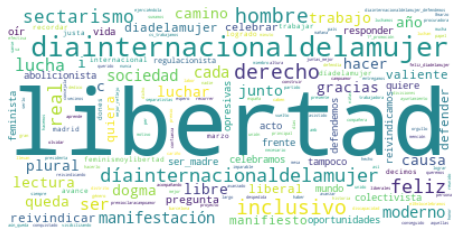

0.668236255645752


In [154]:
start = time.time()

plot_world_cloud(com_24_phrases)
                 
end = time.time()
print(end - start)

In [174]:
count = 0
for tweet in com_24_tweets:
    if 'sectarismo' in tweet.lower():
        print(tweet)
        count +=1
    if count >= 10:
        break

💜 Defendemos un feminismo plural, inclusivo y moderno, sin dogmas ni sectarismos.   👉🏽 La vicealcaldesa, Mari Carmen Sánchez, junto al resto de concejales despliegan la pancarta del #8M en el balcón del Ayuntamiento de #Alicante. #DíaInternacionalDeLaMujer https://t.co/kWu1ncUsqv

💪 El feminismo es igualdad y libertad.  ⚠️ Pero queda mucho por hacer.  🍊👉 Ante el negacionismo de unos y el sectarismo de otros, en @CiudadanosCs reivindicamos un feminismo plural, moderno e inclusivo.  📽 Hagamos una sociedad mejor. #8Marzo2022 https://t.co/aRok3eXUb3

El feminismo es libertad.  Es la libertad de ser mujer como cada una quiera serlo.  Es la libertad de trabajar por la igualdad como cada una quiera hacerlo.  Es una causa en la que no caben divisiones ni sectarismos.  Es un camino en el que todas, todos, sumamos.  #8M2022 https://t.co/8GAT8sEEvh

El feminismo es libertad.  Es la libertad de ser mujer como cada una quiera serlo.  Es la libertad de trabajar por la igualdad como cada una quiera h

**Detecció temàtiques amb LDA**

In [276]:
start = time.time()

com_24_modelsLDA, com_24_coherences = get_modelsLDA_and_coherences(com_24_phrases, 10, 10)

end = time.time()
print(end - start)

104.34915089607239


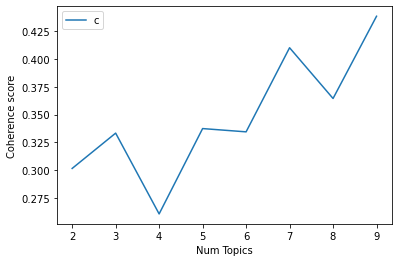

In [277]:
plot_coherences(com_24_coherences, 10)

In [310]:
plot_pyLDAvis(com_24_phrases, com_24_modelsLDA[5])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.195504  0.060004       1        1  18.839591
0      0.043783 -0.110436       2        1  15.426318
3      0.101404 -0.178195       3        1  15.356721
4     -0.151886  0.076620       4        1  14.782009
5     -0.015934 -0.059820       5        1  12.139903
2      0.213812  0.211966       6        1  12.021711
6      0.004325 -0.000139       7        1  11.433748, topic_info=                          Term        Freq       Total Category  logprob  \
116                   libertad  934.000000  934.000000  Default  30.0000   
204                     plural  149.000000  149.000000  Default  29.0000   
187                      lucha  202.000000  202.000000  Default  28.0000   
199                  inclusivo  289.000000  289.000000  Default  27.0000   
71   díainternacionaldelamujer  278.000000  278.000000  Default  26.0000   
..                         ...         ...         ...      ...      ...   
441                   realidad   14.531805   24.663558   Topic7  -5.7314   
199                  inclusivo   18.825389  289.076076   Topic7  -5.4725   
186                          l   15.116181   35.368164   Topic7  -5.6919   
54   diainternacionaldelamujer   18.747727  616.647292   Topic7  -5.4766   
71   díainternacionaldelamujer   16.509094  278.185502   Topic7  -5.6038   

     loglift  
116  30.0000  
204  29.0000  
187  28.0000  
199  27.0000  
71   26.0000  
..       ...  
441   1.6396  
199  -0.5629  
186   1.3186  
54   -1.3246  
71   -0.6558  

[409 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
3637      5  0.978958             0
2015      3  0.935234         19_h.
285       2  0.981777  1ª_promoción
568       2  0.950892         30pje
928       2  0.966298            50
...     ...       ...           ...
1733      4  0.954224      víctimas
2091      3  0.137313         vídeo
2091      4  0.851338         vídeo
1259      2  0.973414       últimas
1244      4  0.981682          útil

[652 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 5, 6, 3, 7])

In [311]:
plot_pyLDAvis(com_24_phrases, com_24_modelsLDA[7])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.261638 -0.069618       1        1  15.757910
7      0.166788  0.061844       2        1  12.896995
3     -0.087003  0.063949       3        1  12.858463
0     -0.093792  0.075027       4        1  11.650719
4     -0.058561  0.212593       5        1  11.224628
8     -0.076369 -0.105286       6        1   9.886467
5      0.055462 -0.074497       7        1   9.807468
2     -0.155996 -0.188041       8        1   9.350828
6     -0.012167  0.024030       9        1   6.566522, topic_info=                          Term        Freq       Total Category  logprob  \
116                   libertad  951.000000  951.000000  Default  30.0000   
204                     plural  152.000000  152.000000  Default  29.0000   
199                  inclusivo  295.000000  295.000000  Default  28.0000   
202                    moderno  183.000000  183.000000  Default  27.0000   
187                      lucha  199.000000  199.000000  Default  26.0000   
..                         ...         ...         ...      ...      ...   
622                     luchan   14.836980   64.433435   Topic9  -5.1560   
178                      feliz   19.032129  280.156242   Topic9  -4.9070   
116                   libertad   21.682463  951.231978   Topic9  -4.7766   
71   díainternacionaldelamujer   14.757586  275.391135   Topic9  -5.1614   
121                  valientes   12.957306   88.449463   Topic9  -5.2915   

     loglift  
116  30.0000  
204  29.0000  
199  28.0000  
202  27.0000  
187  26.0000  
..       ...  
622   1.2547  
178   0.0340  
116  -1.0581  
71   -0.2032  
121   0.8024  

[530 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
3637      1  0.915628             0
285       1  0.991012  1ª_promoción
568       9  0.953922         30pje
928       4  0.986402            50
351       2  0.337649             8
...     ...       ...           ...
1662      3  0.288318            és
1662      6  0.183475            és
1662      8  0.524215            és
1259      2  0.941948       últimas
1244      5  0.955788          útil

[822 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 8, 4, 1, 5, 9, 6, 3, 7])

In [312]:
pprint(com_24_modelsLDA[5].print_topics())

[(0,
  '0.015*"diainternacionaldelamujer" + 0.014*"libertad" + 0.013*"hombre" + '
  '0.010*"feliz" + 0.010*"derechos" + 0.009*"honor" + '
  '0.009*"premioclaracampoamor" + 0.009*"ser" + 0.009*"gracias" + '
  '0.008*"sociedad"'),
 (1,
  '0.077*"libertad" + 0.021*"diainternacionaldelamujer" + 0.019*"feliz" + '
  '0.019*"inclusivo" + 0.017*"cada" + 0.014*"quiera" + 0.014*"trabajo" + '
  '0.013*"defender" + 0.013*"preguntas" + 0.013*"abolicionista"'),
 (2,
  '0.014*"diainternacionaldelamujer" + 0.011*"gracias" + 0.010*"orgullo" + '
  '0.010*"libertad" + 0.009*"luchan" + 0.009*"mesa" + 0.008*"haber" + '
  '0.008*"cariño" + 0.008*"espero" + 0.008*"aquellas"'),
 (3,
  '0.032*"diainternacionaldelamujer" + 0.009*"hombre" + 0.009*"derechos" + '
  '0.008*"real" + 0.008*"acto" + 0.008*"per" + 0.007*"siempre" + 0.007*"amb" + '
  '0.006*"feliz" + 0.006*"manifiesto"'),
 (4,
  '0.034*"libertad" + 0.029*"díainternacionaldelamujer" + 0.021*"plural" + '
  '0.020*"moderno" + 0.019*"inclusivo" + 0.019*"sec

In [313]:
pprint(com_24_modelsLDA[7].print_topics())

[(0,
  '0.023*"hombre" + 0.014*"diainternacionaldelamujer" + 0.012*"real" + '
  '0.011*"lograr" + 0.010*"conseguido" + 0.010*"reivindicar" + '
  '0.010*"sociedad" + 0.009*"díainternacionaldelamujer" + 0.008*"necesario" + '
  '0.007*"aún_queda"'),
 (1,
  '0.077*"libertad" + 0.019*"cada" + 0.018*"feliz" + '
  '0.018*"diainternacionaldelamujer" + 0.018*"quiera" + 0.018*"inclusivo" + '
  '0.018*"ser" + 0.016*"trabajo" + 0.016*"defender" + 0.016*"luchar"'),
 (2,
  '0.016*"diainternacionaldelamujer" + 0.013*"gracias" + 0.012*"orgullo" + '
  '0.011*"mesa" + 0.011*"haber" + 0.011*"cariño" + 0.010*"espero" + '
  '0.010*"altura" + 0.010*"despedida" + 0.010*"minuto"'),
 (3,
  '0.029*"diainternacionaldelamujer" + 0.009*"feliz" + 0.008*"acto" + '
  '0.008*"per" + 0.007*"real" + 0.007*"lectura" + 0.007*"derechos" + '
  '0.006*"dones" + 0.006*"manifiesto" + 0.006*"hombre"'),
 (4,
  '0.028*"díainternacionaldelamujer" + 0.019*"sociedad" + 0.018*"decimos" + '
  '0.015*"libertad" + 0.014*"justa" + 0.013*

Tenint en compte la coherència obtinguda, els gràfics i els termes de cada temàtica elegim k=9.